In [43]:
import pandas as pd
from scipy.stats import ttest_rel
import numpy as np

df = pd.read_csv("spdcm_all_data.csv")
# Define network regions
network_rois = {
    "All Regions": list(range(100)), 
    "LH Visual": list(range(0, 9)),
    "RH Visual": list(range(50, 58)),
    "LH Somatomotor": list(range(9, 15)),
    "RH Somatomotor": list(range(58, 66)),
    "LH Dorsal Attention": list(range(15, 23)),
    "RH Dorsal Attention": list(range(66, 72)),
    "LH Salience/Ventral Attention": list(range(23, 30)),
    "RH Salience/Ventral Attention": list(range(73, 77)),
    "LH Limbic": list(range(30, 33)),
    "RH Limbic": list(range(78, 80)),
    "LH Control": list(range(33, 37)),
    "RH Control": list(range(80, 88)),
    "LH Default Mode": list(range(37, 50)),
    "RH Default Mode": list(range(89, 100))
}

# Define parameters of interest
params = ["phi", "varphi", "chi", "mtt", "tau",
          "alpha_v", "beta_v", "alpha_e", "beta_e",
          "alpha", "E0"]

roi_to_network = {}
for net, rois in network_rois.items():
    for r in rois:
        roi_to_network[r] = net

df["network"] = df["roi"].map(roi_to_network)

# Pivot so each parameter is a separate column
df_pivot = df[df["parameter"].isin(params)].pivot_table(
    index=["subject", "roi", "experiment", "network"],
    columns="parameter",
    values="value"
).reset_index()

# Group by subject, network, condition and compute mean
network_agg = df_pivot.groupby(["subject", "network", "experiment"])[params].mean().reset_index()
network_agg.head()

from scipy.stats import ttest_rel

from statsmodels.stats.multitest import multipletests
from scipy.stats import ttest_1samp


# to interpret Cohen's d 
def interpret_d(d):
    if np.isnan(d):
        return "no data"
    abs_d = abs(d)
    if abs_d < 0.2:
        return "very small"
    elif abs_d < 0.5:
        return "small"
    elif abs_d < 0.8:
        return "medium"
    elif abs_d < 1.3:
        return "large"
    else:
        return "very large"


# Run t-tests per network and parameter
network_results = []

for param in params:
    for network in network_agg["network"].unique():
        net_data = network_agg[network_agg["network"] == network].pivot(index="subject", columns="experiment",
                                                                        values=param).dropna()
        if net_data.shape[0] < 3:
            continue

        diffs = net_data["LSD"] - net_data["PLCB"]
        mean_diff = diffs.mean()
        std_diff = diffs.std(ddof=1)
        cohen_d = mean_diff / std_diff if std_diff != 0 else np.nan
        t_stat, p_val = ttest_rel(net_data["LSD"], net_data["PLCB"])

        network_results.append({
            "network": network,
            "parameter": param,
            "mean_diff": mean_diff,
            "std_diff": std_diff,
            "t_stat": t_stat,
            "p_value": p_val,
            "cohen_d": cohen_d,
            "effect_size": interpret_d(cohen_d)
        })

network_df = pd.DataFrame(network_results)

# Correction methods
pvals = network_df["p_value"].fillna(1).values
rej_fdr, p_fdr, _, _ = multipletests(pvals, method="fdr_bh")
rej_bonf, p_bonf, _, _ = multipletests(pvals, method="bonferroni")
rej_holm, p_holm, _, _ = multipletests(pvals, method="holm")

network_df["p_fdr_bh"] = p_fdr
network_df["reject_fdr_bh"] = rej_fdr
network_df["p_bonferroni"] = p_bonf
network_df["reject_bonferroni"] = rej_bonf
network_df["p_holm"] = p_holm
network_df["reject_holm"] = rej_holm
network_df["reject_raw"] = network_df["p_value"] < 0.05

def interpret_delta(p, mean):
    direction = "↑ LSD > PLCB" if mean > 0 else "↓ LSD < PLCB"
    if p < 0.001:
        return f"highly significant, {direction}"
    elif p < 0.01:
        return f"significant, {direction}"
    elif p < 0.05:
        return f"marginally significant, {direction}"
    else:
        return f"not significant, {direction}"


network_df["interpret_raw"] = network_df.apply(lambda row: interpret_delta(row["p_value"], row["mean_diff"]), axis=1)
network_df["interpret_fdr_bh"] = network_df.apply(lambda row: interpret_delta(row["p_fdr_bh"], row["mean_diff"]),
                                                  axis=1)
network_df["interpret_bonferroni"] = network_df.apply(
    lambda row: interpret_delta(row["p_bonferroni"], row["mean_diff"]), axis=1)
network_df["interpret_holm"] = network_df.apply(lambda row: interpret_delta(row["p_holm"], row["mean_diff"]), axis=1)

network_df = network_df[[
    "network", "parameter", "mean_diff", "std_diff", "cohen_d", "effect_size", "t_stat",
    "p_value", "reject_raw", "interpret_raw",
    "p_fdr_bh", "reject_fdr_bh", "interpret_fdr_bh",
    "p_bonferroni", "reject_bonferroni", "interpret_bonferroni",
    "p_holm", "reject_holm", "interpret_holm"
]]

network_df.sort_values("network", inplace=True)
network_df.reset_index(drop=True, inplace=True)
network_df.to_csv("spdcm_network_ttest_results.csv", index=False)

network_df



network parameter  mean_diff  std_diff   cohen_d effect_size  \
0    All Regions       phi   0.002019  0.197039  0.010246  very small   
1    All Regions     alpha   0.030880  0.093236  0.331205       small   
2    All Regions       mtt   0.699568  1.319242  0.530280      medium   
3    All Regions    beta_e  -0.062221  0.169667 -0.366725       small   
4    All Regions       chi  -0.026222  0.097039 -0.270224       small   
..           ...       ...        ...       ...       ...         ...   
160    RH Visual       mtt   0.243695  0.438877  0.555270      medium   
161    RH Visual       phi   0.001060  0.098778  0.010732  very small   
162    RH Visual     alpha   0.003301  0.049381  0.066853  very small   
163    RH Visual       tau   1.151907  4.782878  0.240840       small   
164    RH Visual        E0  -0.009832  0.067716 -0.145199  very small   

       t_stat   p_value  reject_raw                         interpret_raw  \
0    0.039684  0.968905       False         not significant, ↑ LSD > PLCB   
1    1.282753  0.220410       False         not significant, ↑ LSD > PLCB   
2    2.053766  0.059169       False         not significant, ↑ LSD > PLCB   
3   -1.420318  0.177401       False         not significant, ↓ LSD < PLCB   
4   -1.046573  0.313030       False         not significant, ↓ LSD < PLCB   
..        ...       ...         ...                                   ...   
160  2.150550  0.049466        True  marginally significant, ↑ LSD > PLCB   
161  0.041566  0.967432       False         not significant, ↑ LSD > PLCB   
162  0.258920  0.799465       False         not significant, ↑ LSD > PLCB   
163  0.932768  0.366748       False         not significant, ↑ LSD > PLCB   
164 -0.562351  0.582770       False         not significant, ↓ LSD < PLCB   

     p_fdr_bh  reject_fdr_bh               interpret_fdr_bh  p_bonferroni  \
0    0.990267          False  not significant, ↑ LSD > PLCB           1.0   
1    0.806846          False  not significant, ↑ LSD > PLCB           1.0   
2    0.707971          False  not significant, ↑ LSD > PLCB           1.0   
3    0.805621          False  not significant, ↓ LSD < PLCB           1.0   
4    0.806846          False  not significant, ↓ LSD < PLCB           1.0   
..        ...            ...                            ...           ...   
160  0.707971          False  not significant, ↑ LSD > PLCB           1.0   
161  0.990267          False  not significant, ↑ LSD > PLCB           1.0   
162  0.962661          False  not significant, ↑ LSD > PLCB           1.0   
163  0.806846          False  not significant, ↑ LSD > PLCB           1.0   
164  0.882153          False  not significant, ↓ LSD < PLCB           1.0   

     reject_bonferroni           interpret_bonferroni  p_holm  reject_holm  \
0                False  not significant, ↑ LSD > PLCB     1.0        False   
1                False  not significant, ↑ LSD > PLCB     1.0        False   
2                False  not significant, ↑ LSD > PLCB     1.0        False   
3                False  not significant, ↓ LSD < PLCB     1.0        False   
4                False  not significant, ↓ LSD < PLCB     1.0        False   
..                 ...                            ...     ...          ...   
160              False  not significant, ↑ LSD > PLCB     1.0        False   
161              False  not significant, ↑ LSD > PLCB     1.0        False   
162              False  not significant, ↑ LSD > PLCB     1.0        False   
163              False  not significant, ↑ LSD > PLCB     1.0        False   
164              False  not significant, ↓ LSD < PLCB     1.0        False   

                    interpret_holm  
0    not significant, ↑ LSD > PLCB  
1    not significant, ↑ LSD > PLCB  
2    not significant, ↑ LSD > PLCB  
3    not significant, ↓ LSD < PLCB  
4    not significant, ↓ LSD < PLCB  
..                             ...  
160  not significant, ↑ LSD > PLCB  
161  not significant, ↑ LSD > PLCB  
162  not sig

In [44]:
significant_uncorrected = network_df[network_df["reject_raw"] == True]
significant_uncorrected


network parameter  mean_diff  std_diff   cohen_d  \
34             LH Dorsal Attention   alpha_v   0.068104  0.112293  0.606484   
44                       LH Limbic   alpha_e   0.154962  0.235045  0.659286   
64   LH Salience/Ventral Attention   alpha_e   0.125736  0.164410  0.764772   
74                  LH Somatomotor       chi  -0.052327  0.085798 -0.609883   
103                RH Default Mode     alpha  -0.030530  0.050513 -0.604410   
118            RH Dorsal Attention       tau  -2.648070  4.278532 -0.618920   
122                      RH Limbic    beta_e  -0.142969  0.228674 -0.625207   
152                 RH Somatomotor   alpha_e   0.125661  0.212542  0.591228   
160                      RH Visual       mtt   0.243695  0.438877  0.555270   

    effect_size    t_stat   p_value  reject_raw  \
34       medium  2.348901  0.034035        True   
44       medium  2.553404  0.022965        True   
64       medium  2.961949  0.010299        True   
74       medium -2.362067  0.033191        True   
103      medium -2.340869  0.034559        True   
118      medium -2.397068  0.031043        True   
122      medium -2.421415  0.029627        True   
152      medium  2.289817  0.038078        True   
160      medium  2.150550  0.049466        True   

                            interpret_raw  p_fdr_bh  reject_fdr_bh  \
34   marginally significant, ↑ LSD > PLCB  0.707971          False   
44   marginally significant, ↑ LSD > PLCB  0.707971          False   
64   marginally significant, ↑ LSD > PLCB  0.707971          False   
74   marginally significant, ↓ LSD < PLCB  0.707971          False   
103  marginally significant, ↓ LSD < PLCB  0.707971          False   
118  marginally significant, ↓ LSD < PLCB  0.707971          False   
122  marginally significant, ↓ LSD < PLCB  0.707971          False   
152  marginally significant, ↑ LSD > PLCB  0.707971          False   
160  marginally significant, ↑ LSD > PLCB  0.707971          False   

                  interpret_fdr_bh  p_bonferroni  reject_bonferroni  \
34   not significant, ↑ LSD > PLCB           1.0              False   
44   not significant, ↑ LSD > PLCB           1.0              False   
64   not significant, ↑ LSD > PLCB           1.0              False   
74   not significant, ↓ LSD < PLCB           1.0              False   
103  not significant, ↓ LSD < PLCB           1.0              False   
118  not significant, ↓ LSD < PLCB           1.0              False   
122  not significant, ↓ LSD < PLCB           1.0              False   
152  not significant, ↑ LSD > PLCB           1.0              False   
160  not significant, ↑ LSD > PLCB           1.0              False   

              interpret_bonferroni  p_holm  reject_holm  \
34   not significant, ↑ LSD > PLCB     1.0        False   
44   not significant, ↑ LSD > PLCB     1.0        False   
64   not significant, ↑ LSD > PLCB     1.0        False   
74   not significant, ↓ LSD < PLCB     1.0        False   
103  not significant, ↓ LSD < PLCB     1.0        False   
118  not significant, ↓ LSD < PLCB     1.0        False   
122  not significant, ↓ LSD < PLCB     1.0        False   
152  not significant, ↑ LSD > PLCB     1.0        False   
160  not significant, ↑ LSD > PLCB     1.0        False   

                    interpret_holm  
34   not significant, ↑ LSD > PLCB  
44   not significant, ↑ LSD > PLCB  
64   not significant, ↑ LSD > PLCB  
74   not significant, ↓ LSD < PLCB  
103  not significant, ↓ LSD < PLCB  
118  not significant, ↓ LSD < PLCB  
122  not significant, ↓ LSD < PLCB  
152  not significant, ↑ LSD > PLCB  
160  not significant, ↑ LSD > PLCB

In [45]:
# FDR BH significant
sig_fdr = network_df[network_df["reject_fdr_bh"] == True]
sig_fdr

Empty DataFrame
Columns: [network, parameter, mean_diff, std_diff, cohen_d, effect_size, t_stat, p_value, reject_raw, interpret_raw, p_fdr_bh, reject_fdr_bh, interpret_fdr_bh, p_bonferroni, reject_bonferroni, interpret_bonferroni, p_holm, reject_holm, interpret_holm]
Index: []

In [46]:
# Bonferroni significant
sig_bonf = network_df[network_df["reject_bonferroni"] == True]
sig_bonf

Empty DataFrame
Columns: [network, parameter, mean_diff, std_diff, cohen_d, effect_size, t_stat, p_value, reject_raw, interpret_raw, p_fdr_bh, reject_fdr_bh, interpret_fdr_bh, p_bonferroni, reject_bonferroni, interpret_bonferroni, p_holm, reject_holm, interpret_holm]
Index: []

In [47]:
# Holm significant
sig_holm = network_df[network_df["reject_holm"] == True]
sig_holm

Empty DataFrame
Columns: [network, parameter, mean_diff, std_diff, cohen_d, effect_size, t_stat, p_value, reject_raw, interpret_raw, p_fdr_bh, reject_fdr_bh, interpret_fdr_bh, p_bonferroni, reject_bonferroni, interpret_bonferroni, p_holm, reject_holm, interpret_holm]
Index: []

In [48]:
# Filter where the tests show significant difference
sig = network_df[
    (network_df["reject_raw"] == True) &
    (network_df["reject_fdr_bh"] == True) &
    (network_df["reject_bonferroni"] == True) &
    (network_df["reject_holm"] == True)
    ]
sig = sig.sort_values("network")

sig


Empty DataFrame
Columns: [network, parameter, mean_diff, std_diff, cohen_d, effect_size, t_stat, p_value, reject_raw, interpret_raw, p_fdr_bh, reject_fdr_bh, interpret_fdr_bh, p_bonferroni, reject_bonferroni, interpret_bonferroni, p_holm, reject_holm, interpret_holm]
Index: []

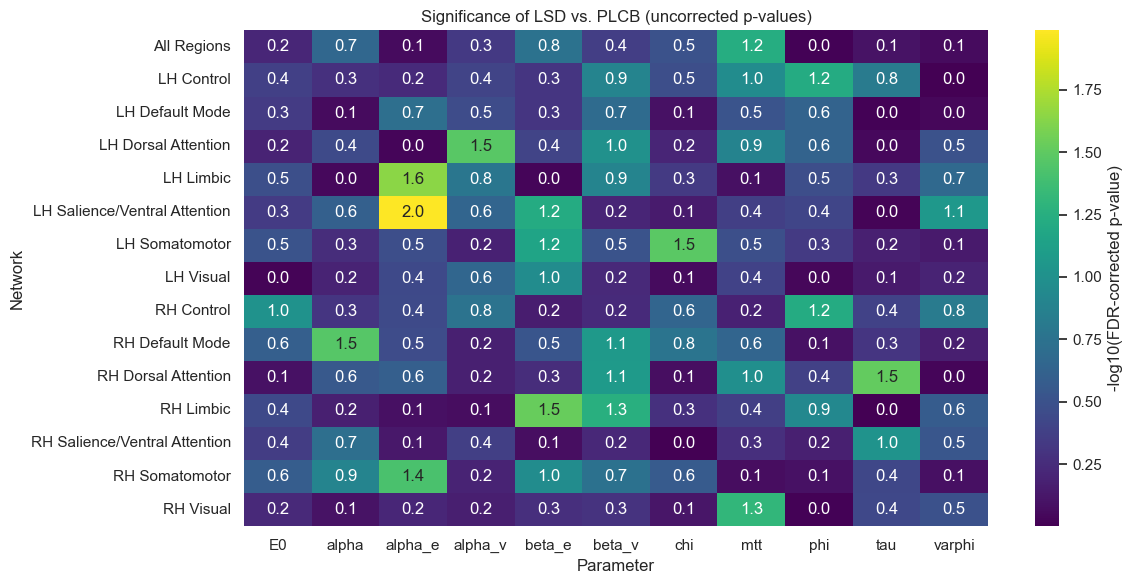

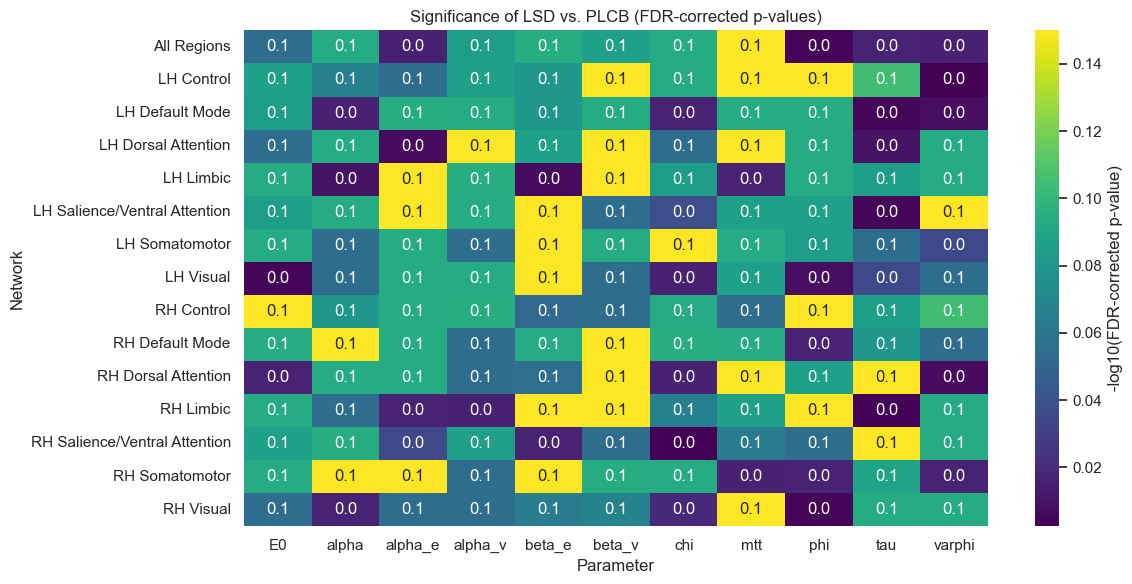

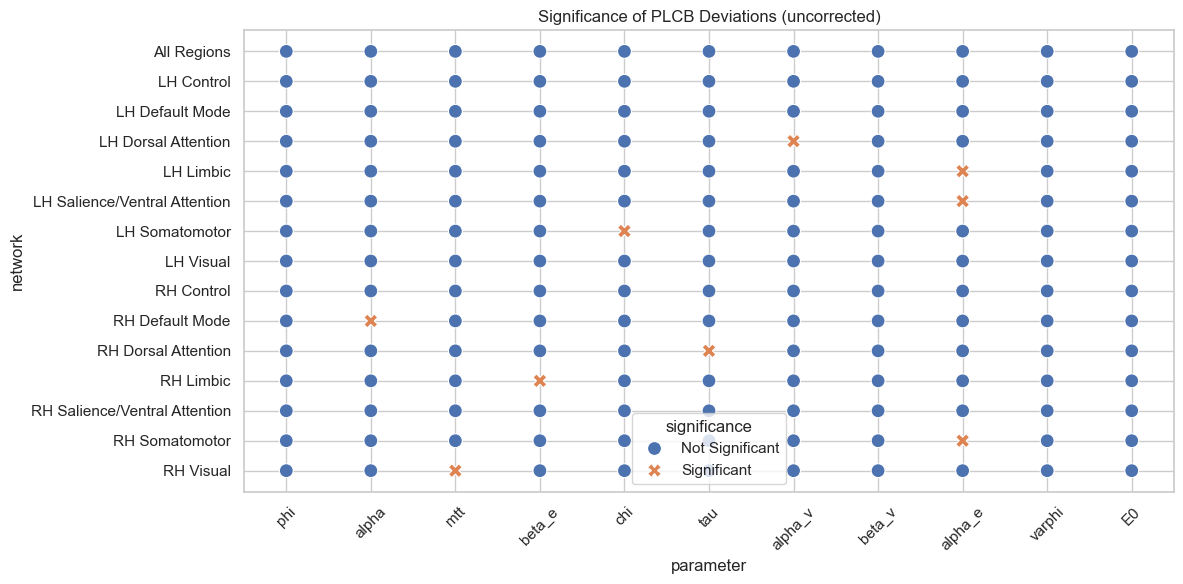

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Pivot p-values for heatmap 
heatmap_data_uncorrected = network_df.pivot(index="network", columns="parameter", values="p_value")

plt.figure(figsize=(12, 6))
sns.heatmap(
    -np.log10(heatmap_data_uncorrected),
    cmap="viridis",
    cbar_kws={"label": "-log10(FDR-corrected p-value)"},
    annot=True, fmt=".1f"
)
plt.title("Significance of LSD vs. PLCB (uncorrected p-values)")
plt.ylabel("Network")
plt.xlabel("Parameter")
plt.tight_layout()
plt.show()

# Pivot p-values for heatmap 
heatmap_data = network_df.pivot(index="network", columns="parameter", values="p_fdr_bh")

plt.figure(figsize=(12, 6))
sns.heatmap(
    -np.log10(heatmap_data),
    cmap="viridis",
    cbar_kws={"label": "-log10(FDR-corrected p-value)"},
    annot=True, fmt=".1f"
)
plt.title("Significance of LSD vs. PLCB (FDR-corrected p-values)")
plt.ylabel("Network")
plt.xlabel("Parameter")
plt.tight_layout()
plt.show()

#reject_fdr_bh
#reject_bonferroni
#reject_holm

# Mark significance status
network_df["significance"] = network_df["reject_raw"].map({True: "Significant", False: "Not Significant"})

plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=network_df,
    x="parameter", y="network",
    hue="significance", style="significance",
    s=100
)
plt.title("Significance of PLCB Deviations (uncorrected)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



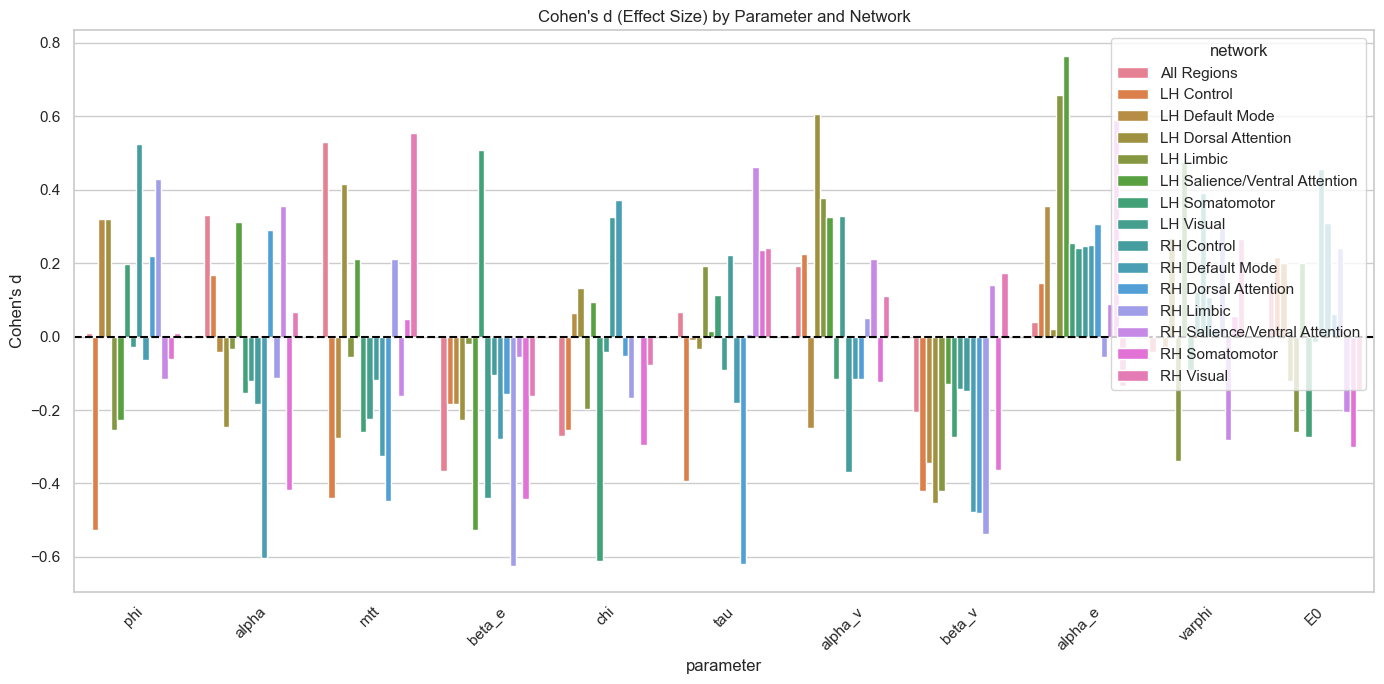

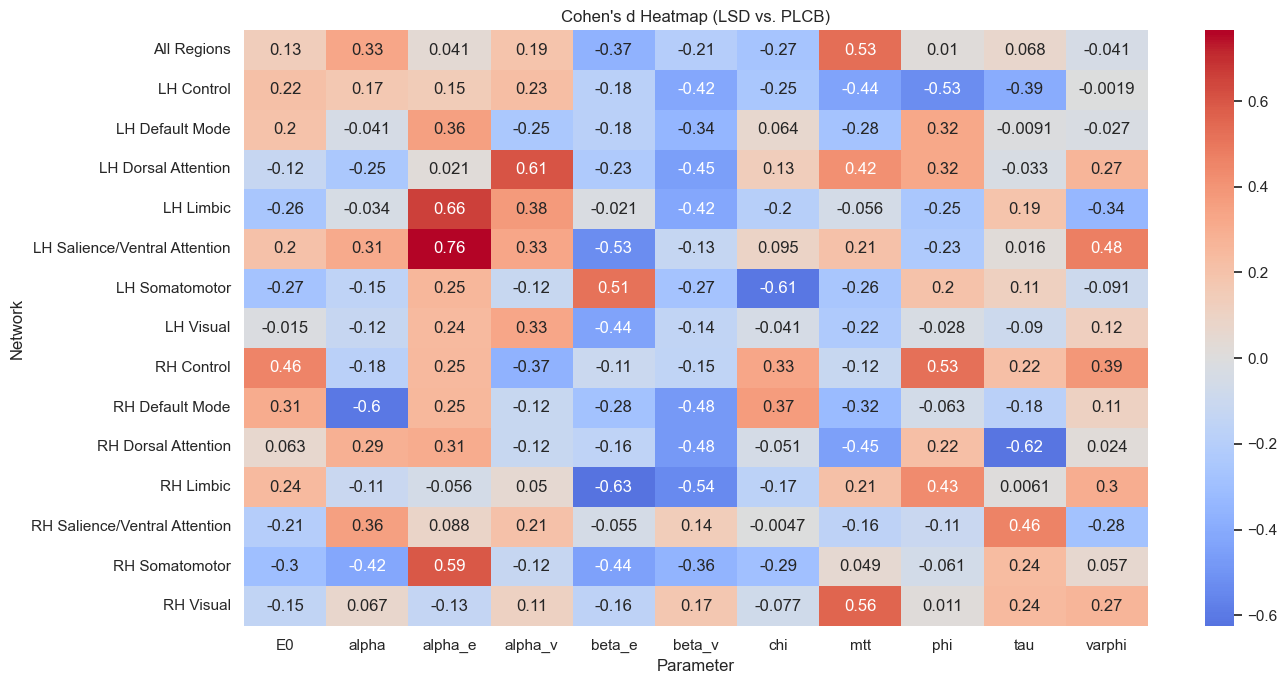

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 7))
sns.barplot(
    data=network_df,
    x="parameter", y="cohen_d",
    hue="network",
    dodge=True
)
plt.axhline(0, color="black", linestyle="--")
plt.title("Cohen's d (Effect Size) by Parameter and Network")
plt.ylabel("Cohen's d")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

pivot_d = network_df.pivot(index="network", columns="parameter", values="cohen_d")

plt.figure(figsize=(14, 7))
sns.heatmap(pivot_d, annot=True, cmap="coolwarm", center=0)
plt.title("Cohen's d Heatmap (LSD vs. PLCB)")
plt.xlabel("Parameter")
plt.ylabel("Network")
plt.tight_layout()
plt.show()




paired test for each roi

In [51]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_rel
from statsmodels.stats.multitest import multipletests

df = pd.read_csv("spdcm_all_data.csv")

# Define parameters of interest
params = ["A_real","A_imag", "phi", "varphi", "chi", "mtt", "tau",
          "alpha", "E0","alpha_v", "beta_v", "alpha_e", "beta_e"]

# Pivot so each parameter is a separate column
df_pivot = df[df["parameter"].isin(params)].pivot_table(
    index=["subject", "roi", "experiment"],
    columns="parameter",
    values="value"
).reset_index()

# Group by subject, ROI, experiment and compute mean values
roi_agg = df_pivot.groupby(["subject", "roi", "experiment"])[params].mean().reset_index()


def interpret_d(d):
    if np.isnan(d):
        return "no data"
    abs_d = abs(d)
    if abs_d < 0.2:
        return "very small"
    elif abs_d < 0.5:
        return "small"
    elif abs_d < 0.8:
        return "medium"
    elif abs_d < 1.3:
        return "large"
    else:
        return "very large"


# Run t-tests per ROI and parameter 
roi_results = []

for param in params:
    for roi in roi_agg["roi"].unique():
        roi_data = roi_agg[roi_agg["roi"] == roi].pivot(index="subject", columns="experiment", values=param).dropna()

        if roi_data.shape[0] < 3:
            continue

        diffs = roi_data["LSD"] - roi_data["PLCB"]
        mean_diff = diffs.mean()
        std_diff = diffs.std(ddof=1)
        cohen_d = mean_diff / std_diff if std_diff != 0 else np.nan
        t_stat, p_val = ttest_rel(roi_data["LSD"], roi_data["PLCB"])

        roi_results.append({
            "roi": roi,
            "parameter": param,
            "mean_diff": mean_diff,
            "std_diff": std_diff,
            "t_stat": t_stat,
            "p_value": p_val,
            "cohen_d": cohen_d,
            "effect_size": interpret_d(cohen_d)
        })

roi_df = pd.DataFrame(roi_results)

# Correction methods 
pvals = roi_df["p_value"].fillna(1).values
rej_fdr, p_fdr, _, _ = multipletests(pvals, method="fdr_bh")
rej_bonf, p_bonf, _, _ = multipletests(pvals, method="bonferroni")
rej_holm, p_holm, _, _ = multipletests(pvals, method="holm")

roi_df["p_fdr_bh"] = p_fdr
roi_df["reject_fdr_bh"] = rej_fdr
roi_df["p_bonferroni"] = p_bonf
roi_df["reject_bonferroni"] = rej_bonf
roi_df["p_holm"] = p_holm
roi_df["reject_holm"] = rej_holm
roi_df["reject_raw"] = roi_df["p_value"] < 0.05


def interpret_delta(p, mean):
    direction = "↑ LSD > PLCB" if mean > 0 else "↓ LSD < PLCB"
    if p < 0.001:
        return f"highly significant, {direction}"
    elif p < 0.01:
        return f"significant, {direction}"
    elif p < 0.05:
        return f"marginally significant, {direction}"
    else:
        return f"not significant, {direction}"


roi_df["interpret_raw"] = roi_df.apply(lambda row: interpret_delta(row["p_value"], row["mean_diff"]), axis=1)
roi_df["interpret_fdr_bh"] = roi_df.apply(lambda row: interpret_delta(row["p_fdr_bh"], row["mean_diff"]), axis=1)
roi_df["interpret_bonferroni"] = roi_df.apply(lambda row: interpret_delta(row["p_bonferroni"], row["mean_diff"]),
                                              axis=1)
roi_df["interpret_holm"] = roi_df.apply(lambda row: interpret_delta(row["p_holm"], row["mean_diff"]), axis=1)

roi_df = roi_df[[
    "roi", "parameter", "mean_diff", "std_diff", "cohen_d", "effect_size", "t_stat",
    "p_value", "reject_raw", "interpret_raw",
    "p_fdr_bh", "reject_fdr_bh", "interpret_fdr_bh",
    "p_bonferroni", "reject_bonferroni", "interpret_bonferroni",
    "p_holm", "reject_holm", "interpret_holm"
]]

roi_df.sort_values(["roi", "parameter"], inplace=True)
roi_df.reset_index(drop=True, inplace=True)
roi_df.to_csv("spdcm_roi_ttest_results.csv", index=False)
roi_df


roi parameter  mean_diff  std_diff   cohen_d effect_size    t_stat  \
0       0    A_imag   0.025964  0.064918  0.399947       small  1.548987   
1       0    A_real   0.080000  0.139745  0.572472      medium  2.217174   
2       0        E0  -0.030489  0.146452 -0.208186       small -0.806303   
3       0     alpha   0.014248  0.188847  0.075446  very small  0.292202   
4       0   alpha_e  -0.055180  0.408398 -0.135114  very small -0.523296   
...   ...       ...        ...       ...       ...         ...       ...   
1295   99       chi   0.010757  0.253526  0.042431  very small  0.164333   
1296   99       mtt  -0.348699  1.548083 -0.225246       small -0.872373   
1297   99       phi  -0.063104  0.342226 -0.184393  very small -0.714150   
1298   99       tau  -1.394943  5.873959 -0.237479       small -0.919753   
1299   99    varphi  -0.052821  0.215843 -0.244719       small -0.947791   

       p_value  reject_raw                         interpret_raw  p_fdr_bh  \
0     0.143689       False         not significant, ↑ LSD > PLCB  0.932291   
1     0.043670        True  marginally significant, ↑ LSD > PLCB  0.932291   
2     0.433552       False         not significant, ↓ LSD < PLCB  0.972396   
3     0.774418       False         not significant, ↑ LSD > PLCB  0.986938   
4     0.608952       False         not significant, ↓ LSD < PLCB  0.976126   
...        ...         ...                                   ...       ...   
1295  0.871818       False         not significant, ↑ LSD > PLCB  0.986938   
1296  0.397720       False         not significant, ↓ LSD < PLCB  0.964103   
1297  0.486872       False         not significant, ↓ LSD < PLCB  0.972396   
1298  0.373278       False         not significant, ↓ LSD < PLCB  0.958983   
1299  0.359310       False         not significant, ↓ LSD < PLCB  0.958983   

      reject_fdr_bh               interpret_fdr_bh  p_bonferroni  \
0             False  not significant, ↑ LSD > PLCB           1.0   
1             False  not significant, ↑ LSD > PLCB           1.0   
2             False  not significant, ↓ LSD < PLCB           1.0   
3             False  not significant, ↑ LSD > PLCB           1.0   
4             False  not significant, ↓ LSD < PLCB           1.0   
...             ...                            ...           ...   
1295          False  not significant, ↑ LSD > PLCB           1.0   
1296          False  not significant, ↓ LSD < PLCB           1.0   
1297          False  not significant, ↓ LSD < PLCB           1.0   
1298          False  not significant, ↓ LSD < PLCB           1.0   
1299          False  not significant, ↓ LSD < PLCB           1.0   

      reject_bonferroni           interpret_bonferroni  p_holm  reject_holm  \
0                 False  not significant, ↑ LSD > PLCB     1.0        False   
1                 False  not significant, ↑ LSD > PLCB     1.0        False   
2                 False  not significant, ↓ LSD < PLCB     1.0        False   
3                 False  not significant, ↑ LSD > PLCB     1.0        False   
4                 False  not significant, ↓ LSD < PLCB     1.0        False   
...                 ...                            ...     ...          ...   
1295              False  not significant, ↑ LSD > PLCB     1.0        False   
1296              False  not significant, ↓ LSD < PLCB     1.0        False   
1297              False  not significant, ↓ LSD < PLCB     1.0        False   
1298              False  not significant, ↓ LSD < PLCB     1.0        False   
1299              False  not significant, ↓ LSD < PLCB     1.0        False   

                     interpret_holm  
0     not significant, ↑ LSD > PLCB  
1     not significant, ↑ LSD > PLCB  
2     not significant, ↓ LSD < PLCB  
3     not significant, ↑ LSD > PLCB  
4     not significant, ↓ LSD < PLCB  
...                             ...  
1295  not significant, ↑ LSD > PLCB  
1296  not significant, ↓ LSD < PLCB  
1297  not significant, ↓ LSD < PLCB  
1298  not 

In [52]:
significant_uncorrected_roi = roi_df[roi_df["reject_raw"] == True]
significant_uncorrected_roi


roi parameter  mean_diff  std_diff   cohen_d effect_size    t_stat  \
1       0    A_real   0.080000  0.139745  0.572472      medium  2.217174   
9       0       mtt  -0.733774  1.310399 -0.559962      medium -2.168724   
12      0    varphi   0.109969  0.114393  0.961327       large  3.723204   
29      2     alpha  -0.090693  0.131120 -0.691677      medium -2.678852   
30      2   alpha_e   0.357980  0.362969  0.986255       large  3.819748   
43      3   alpha_e  -0.274468  0.372338 -0.737145      medium -2.854952   
69      5   alpha_e   0.211522  0.342034  0.618424      medium  2.395147   
84      6    beta_e  -0.169200  0.230778 -0.733172      medium -2.839564   
86      6       chi   0.107281  0.193354  0.554841      medium  2.148892   
109     8   alpha_v   0.226356  0.321763  0.703485      medium  2.724585   
136    10    beta_e   0.158600  0.198808  0.797753      medium  3.089686   
138    10       chi  -0.161830  0.160989 -1.005222       large -3.893207   
145    11        E0   0.056463  0.091112  0.619708      medium  2.400118   
146    11     alpha  -0.111511  0.181120 -0.615678      medium -2.384511   
161    12   alpha_v  -0.177946  0.314931 -0.565033      medium -2.188362   
211    16     alpha  -0.109537  0.193703 -0.565491      medium -2.190139   
212    16   alpha_e  -0.161432  0.261236 -0.617956      medium -2.393334   
228    17    beta_v  -0.269070  0.222233 -1.210757       large -4.689241   
287    22    A_real  -0.101690  0.139960 -0.726561      medium -2.813958   
289    22     alpha  -0.123167  0.146881 -0.838551       large -3.247692   
291    22   alpha_v   0.283771  0.388778  0.729904      medium  2.826904   
312    24    A_imag   0.048860  0.070753  0.690568      medium  2.674558   
330    25   alpha_v   0.344305  0.268187  1.283826       large  4.972236   
390    30    A_imag   0.036666  0.056299  0.651271      medium  2.522360   
397    30    beta_v  -0.327439  0.475732 -0.688286      medium -2.665719   
484    37     alpha  -0.091553  0.155485 -0.588821      medium -2.280496   
513    39    beta_e  -0.199336  0.331730 -0.600897      medium -2.327263   
523    40     alpha  -0.101772  0.155046 -0.656396      medium -2.542209   
546    42    A_imag   0.025725  0.045487  0.565543      medium  2.190340   
559    43    A_imag   0.032100  0.053173  0.603693      medium  2.338092   
576    44   alpha_e   0.255826  0.351906  0.726974      medium  2.815559   
593    45       chi  -0.097168  0.164171 -0.591871      medium -2.292306   
602    46   alpha_e   0.195761  0.334865  0.584596      medium  2.264131   
608    46       phi   0.201194  0.347182  0.579505      medium  2.244414   
634    48       phi   0.177406  0.312446  0.567796      medium  2.199064   
637    49    A_imag   0.056539  0.061837  0.914322       large  3.541154   
657    50    beta_v   0.225142  0.295813  0.761096      medium  2.947713   
663    51    A_imag   0.030679  0.043591  0.703775      medium  2.725710   
739    56       tau   5.753710  7.443989  0.772934      medium  2.993559   
758    58   alpha_e   0.284955  0.495523  0.575060      medium  2.227196   
826    63    beta_v  -0.188157  0.337059 -0.558232      medium -2.162022   
862    66   alpha_e   0.223548  0.360845  0.619512      medium  2.399359   
864    66    beta_e  -0.260475  0.276101 -0.943405       large -3.653793   
911    70    A_real  -0.093676  0.121715 -0.769636      medium -2.980786   
922    70    varphi  -0.164729  0.179848 -0.915930       large -3.547383   
945    72       mtt   1.238120  1.597471  0.775050      medium  3.001754   
997    76       mtt   0.861273  1.450050  0.593960      medium  2.300399   
1021   78    beta_v  -0.279778  0.400192 -0.699110      medium -2.707641   
1055   81        E0   0.124643  0.159466  0.781626      medium  3.027226   
1147   88     alpha   0.106416  0.172714  0.616139      medium  2.386297   
1169   89    varphi   0.099084  0.177741  0.557464      medium  2.159050   
1173   90     alpha  -0.094414  0.153982 -0.613151    

In [53]:
# Bonferroni significant
sig_bonf_roi = roi_df[roi_df["reject_bonferroni"] == True]
sig_bonf_roi

Empty DataFrame
Columns: [roi, parameter, mean_diff, std_diff, cohen_d, effect_size, t_stat, p_value, reject_raw, interpret_raw, p_fdr_bh, reject_fdr_bh, interpret_fdr_bh, p_bonferroni, reject_bonferroni, interpret_bonferroni, p_holm, reject_holm, interpret_holm]
Index: []

In [54]:
# FDR BH significant
sig_fdr_roi = roi_df[roi_df["reject_fdr_bh"] == True]
sig_fdr_roi

Empty DataFrame
Columns: [roi, parameter, mean_diff, std_diff, cohen_d, effect_size, t_stat, p_value, reject_raw, interpret_raw, p_fdr_bh, reject_fdr_bh, interpret_fdr_bh, p_bonferroni, reject_bonferroni, interpret_bonferroni, p_holm, reject_holm, interpret_holm]
Index: []

In [55]:
# Holm significant
sig_holm_roi = roi_df[roi_df["reject_holm"] == True]
sig_holm_roi

Empty DataFrame
Columns: [roi, parameter, mean_diff, std_diff, cohen_d, effect_size, t_stat, p_value, reject_raw, interpret_raw, p_fdr_bh, reject_fdr_bh, interpret_fdr_bh, p_bonferroni, reject_bonferroni, interpret_bonferroni, p_holm, reject_holm, interpret_holm]
Index: []

In [56]:
# Filter where  tests show significant difference
sig_roi = roi_df[
    (roi_df["reject_raw"] == True) &
    (roi_df["reject_fdr_bh"] == True) &
    (roi_df["reject_bonferroni"] == True) &
    (roi_df["reject_holm"] == True)
    ]


sig_roi

Empty DataFrame
Columns: [roi, parameter, mean_diff, std_diff, cohen_d, effect_size, t_stat, p_value, reject_raw, interpret_raw, p_fdr_bh, reject_fdr_bh, interpret_fdr_bh, p_bonferroni, reject_bonferroni, interpret_bonferroni, p_holm, reject_holm, interpret_holm]
Index: []

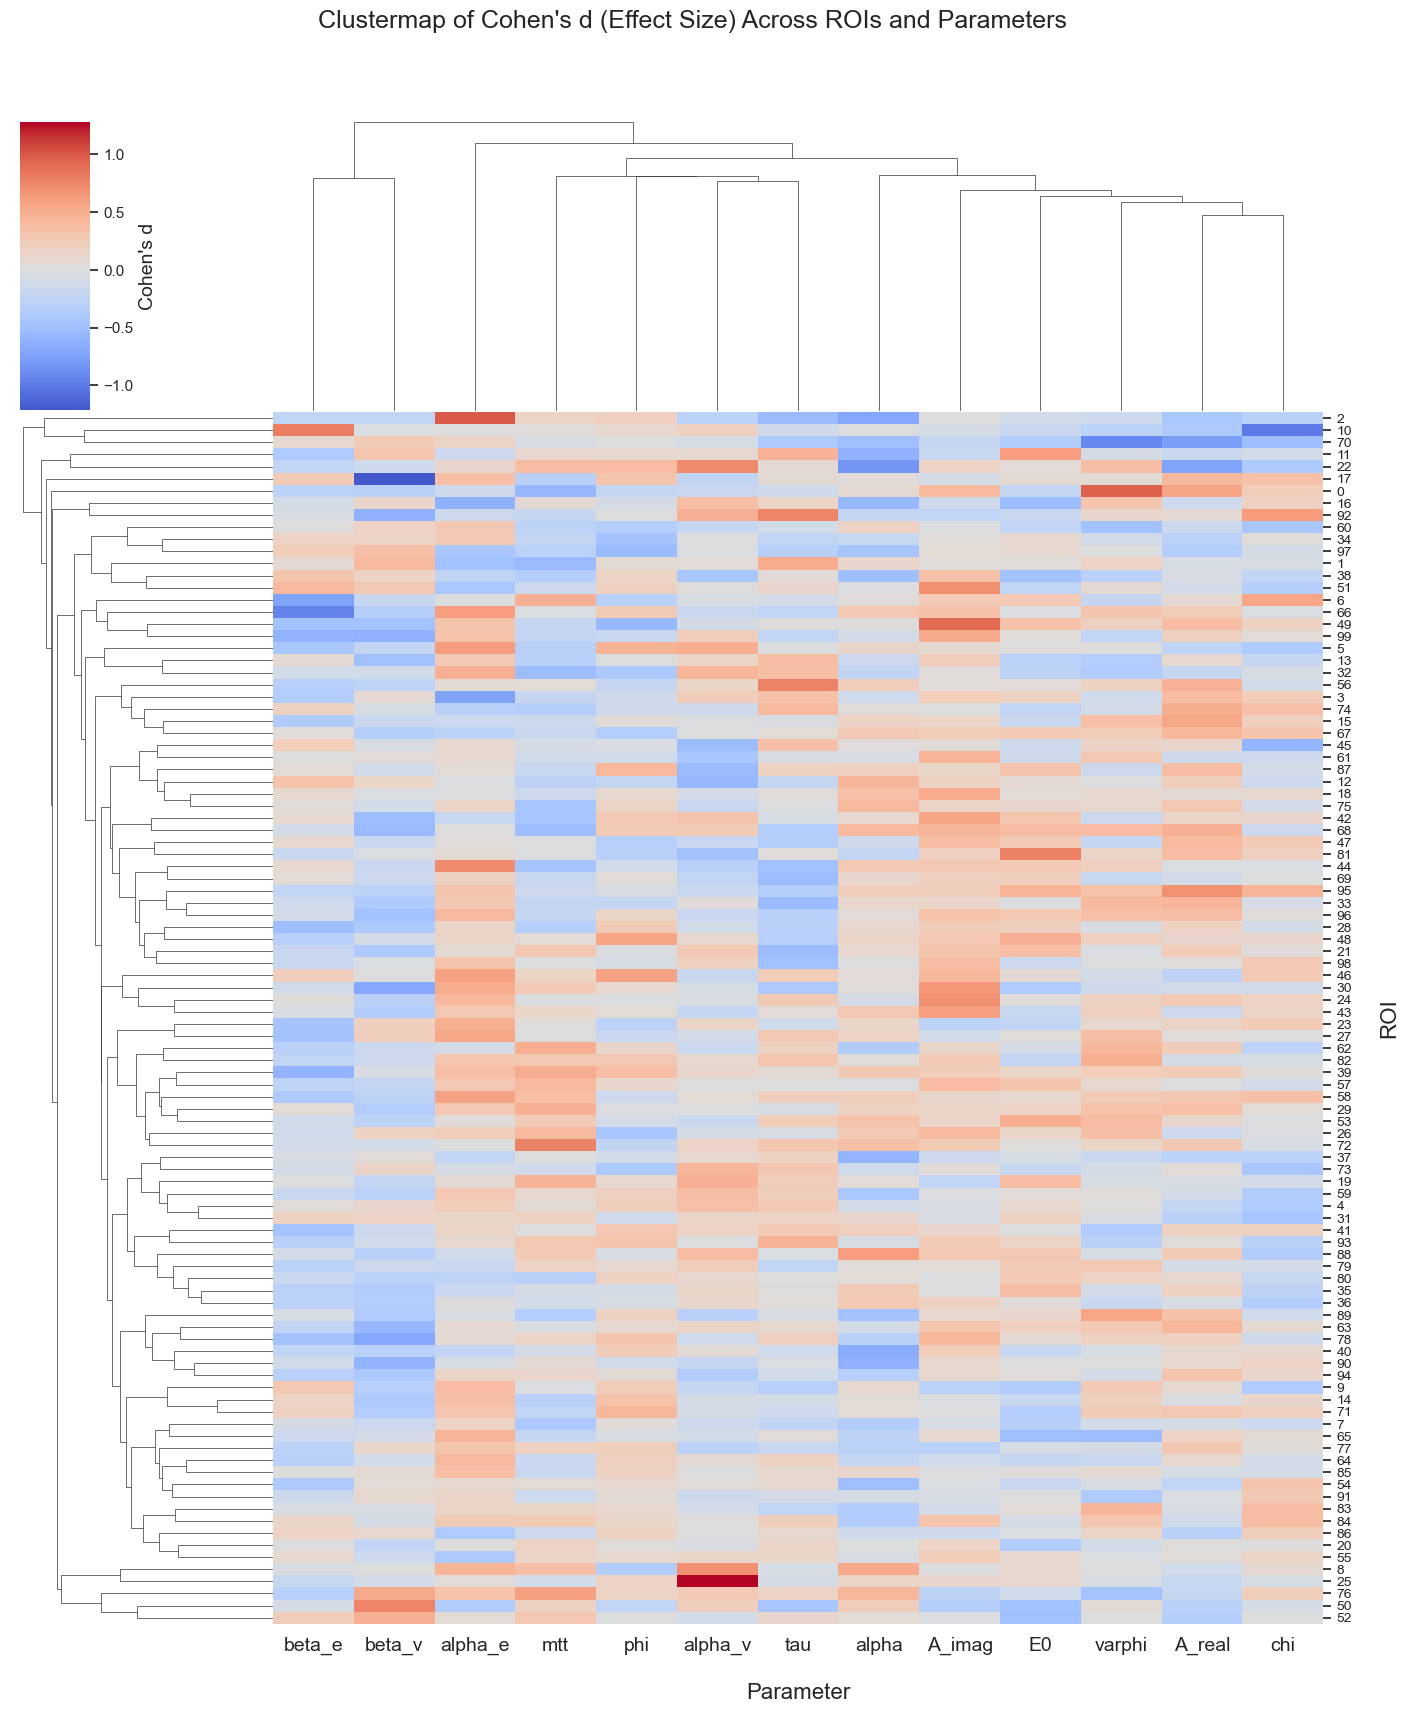

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pivot the DataFrame
pivot_d = roi_df.pivot(index="roi", columns="parameter", values="cohen_d")

h = sns.clustermap(
    pivot_d,
    cmap="coolwarm", center=0,
    figsize=(14, 16),
    yticklabels=True,
    annot=False
)

h.fig.suptitle("Clustermap of Cohen's d (Effect Size) Across ROIs and Parameters", y=1.05, fontsize=18)

plt.setp(h.ax_heatmap.xaxis.get_majorticklabels(), fontsize=14)

plt.setp(h.ax_heatmap.yaxis.get_majorticklabels(), fontsize=10)

h.cax.set_ylabel("Cohen's d", fontsize=14)

h.ax_heatmap.set_xlabel("Parameter", fontsize=16, labelpad=20)

h.ax_heatmap.set_ylabel("ROI", fontsize=16, labelpad=20)


plt.show()


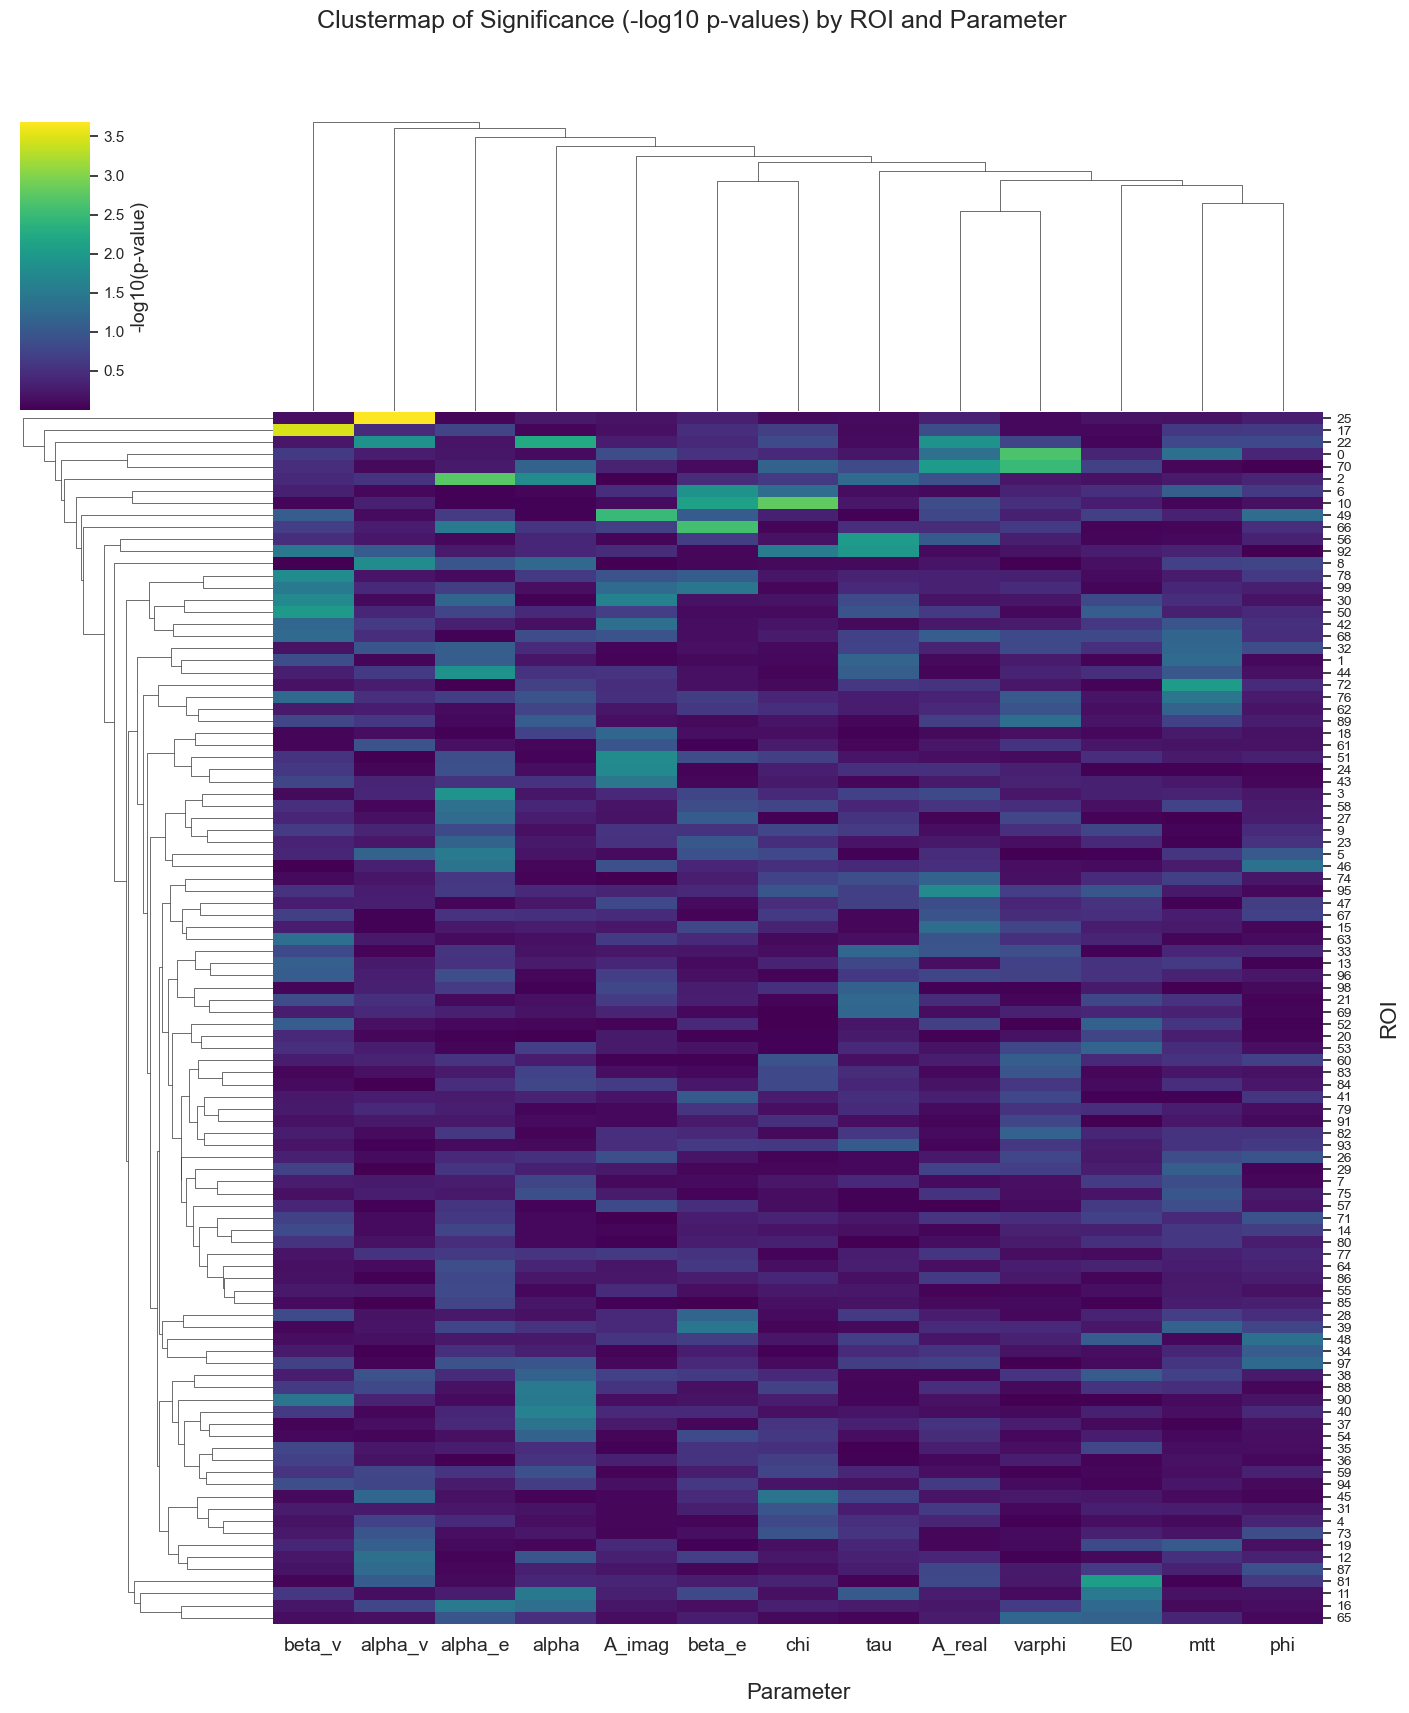

In [59]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare the log-transformed p-values
pivot_pvals = roi_df.pivot(index="roi", columns="parameter", values="p_value")
log_pvals = -np.log10(pivot_pvals).sort_index().clip(upper=10)

# Create clustermap object
g = sns.clustermap(
    log_pvals,
    cmap="viridis",
    figsize=(14, 16),
    yticklabels=True,
    annot=False,
    cbar_kws={"label": "-log10(p-value)"},
)

# === Title font size ===
plt.suptitle(
    "Clustermap of Significance (-log10 p-values) by ROI and Parameter",
    y=1.05, fontsize=18
)


plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), fontsize=14)

plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), fontsize=10)

g.cax.set_ylabel("-log10(p-value)", fontsize=14)

g.ax_heatmap.set_xlabel("Parameter", fontsize=16, labelpad=20)
g.ax_heatmap.set_ylabel("ROI", fontsize=16, labelpad=20)

plt.show()


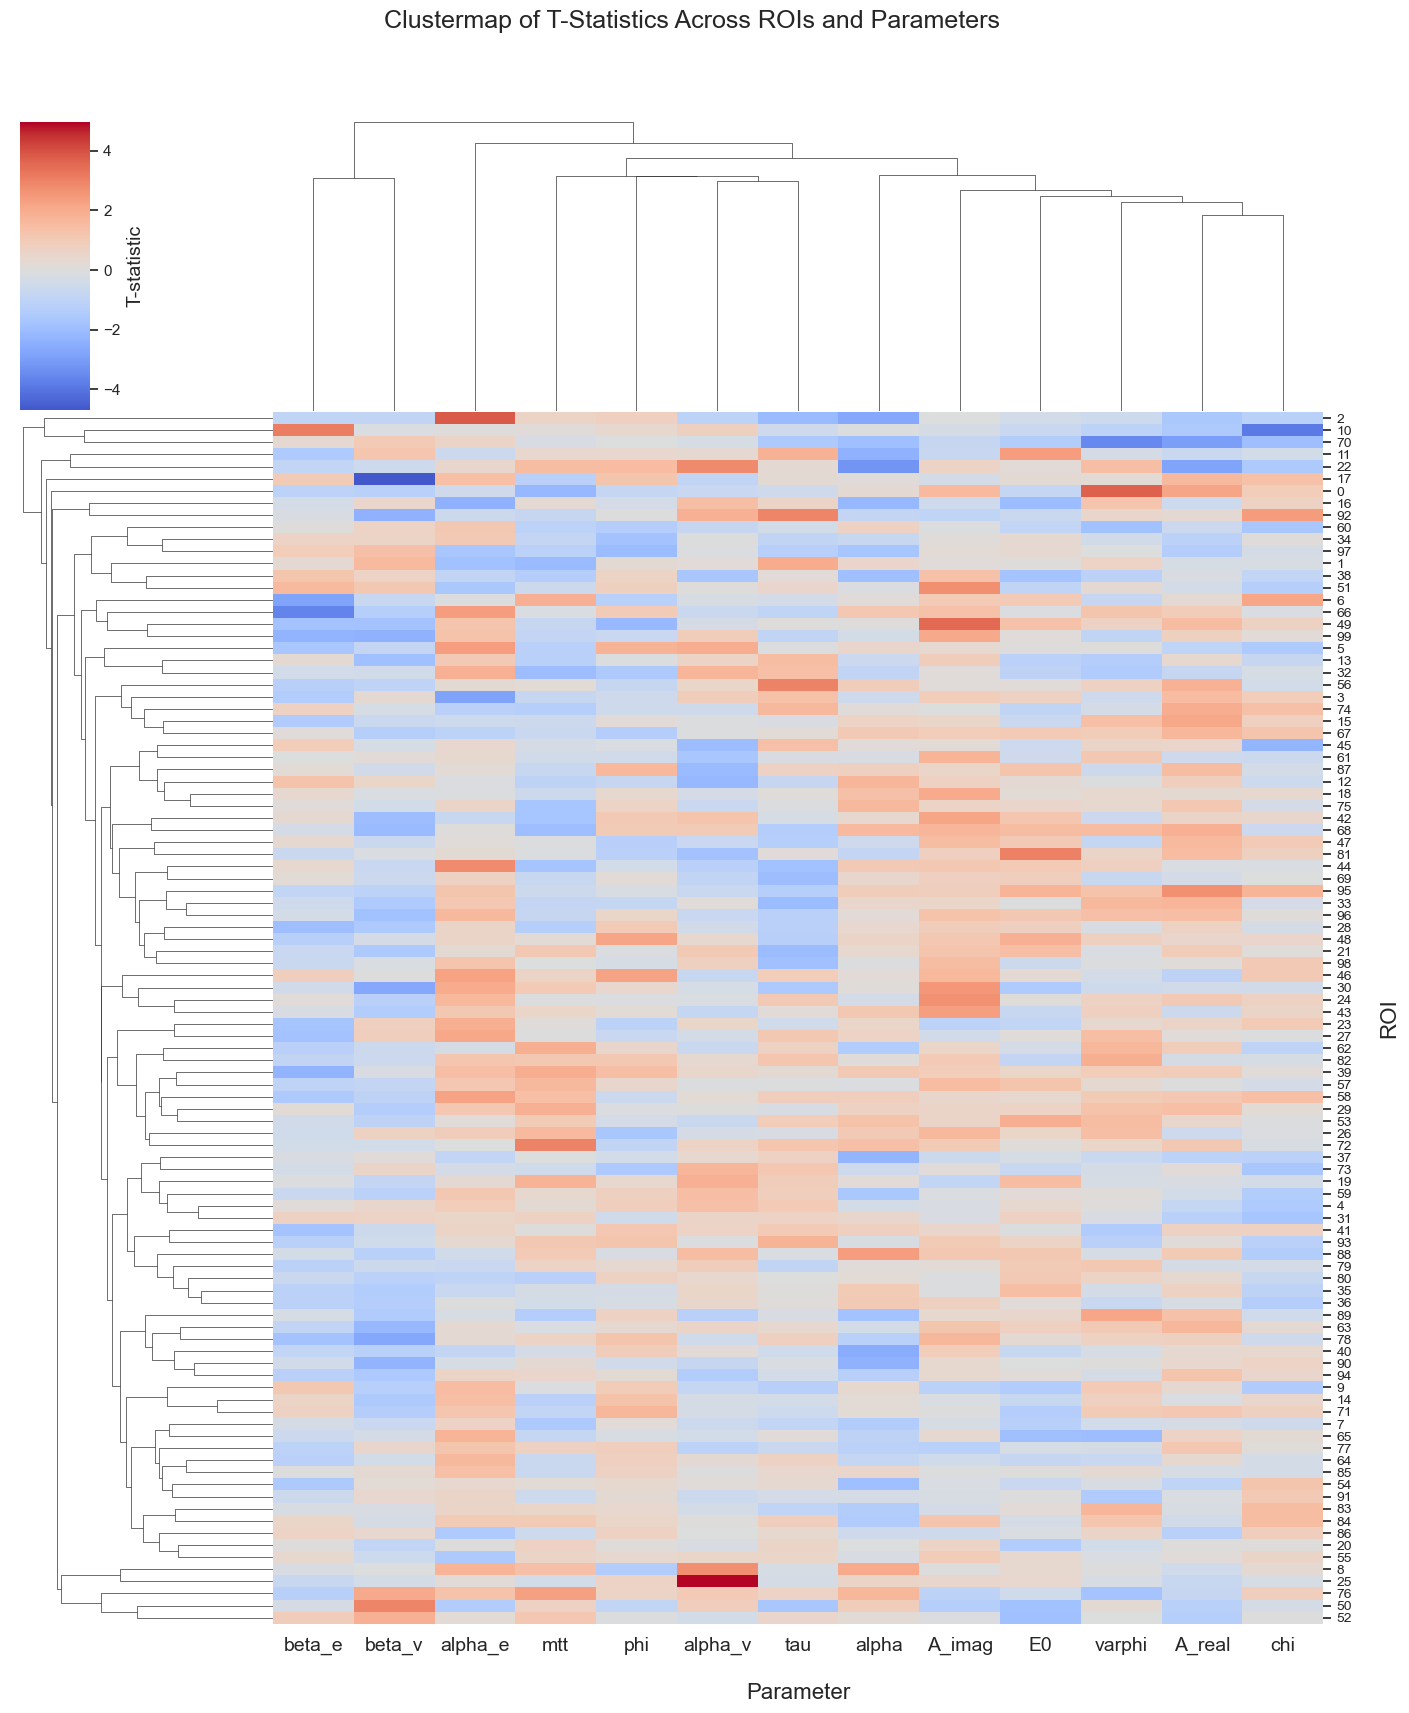

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt
# Pivot the DataFrame for t-statistics
pivot_t = roi_df.pivot(index="roi", columns="parameter", values="t_stat")

h = sns.clustermap(
    pivot_t,
    cmap="coolwarm", center=0,
    figsize=(14, 16),
    yticklabels=True,
    annot=False
)

h.fig.suptitle("Clustermap of T-Statistics Across ROIs and Parameters", y=1.05, fontsize=18)
plt.setp(h.ax_heatmap.xaxis.get_majorticklabels(), fontsize=14)
plt.setp(h.ax_heatmap.yaxis.get_majorticklabels(), fontsize=10)
h.cax.set_ylabel("T-statistic", fontsize=14)
h.ax_heatmap.set_xlabel("Parameter", fontsize=16, labelpad=20)
h.ax_heatmap.set_ylabel("ROI", fontsize=16, labelpad=20)
plt.show()


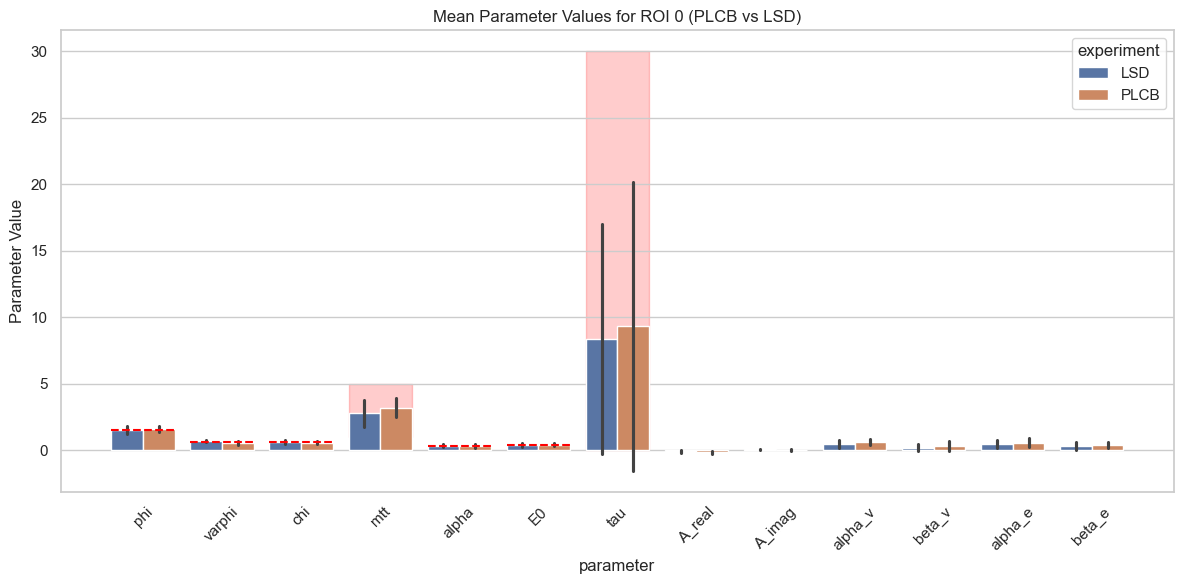

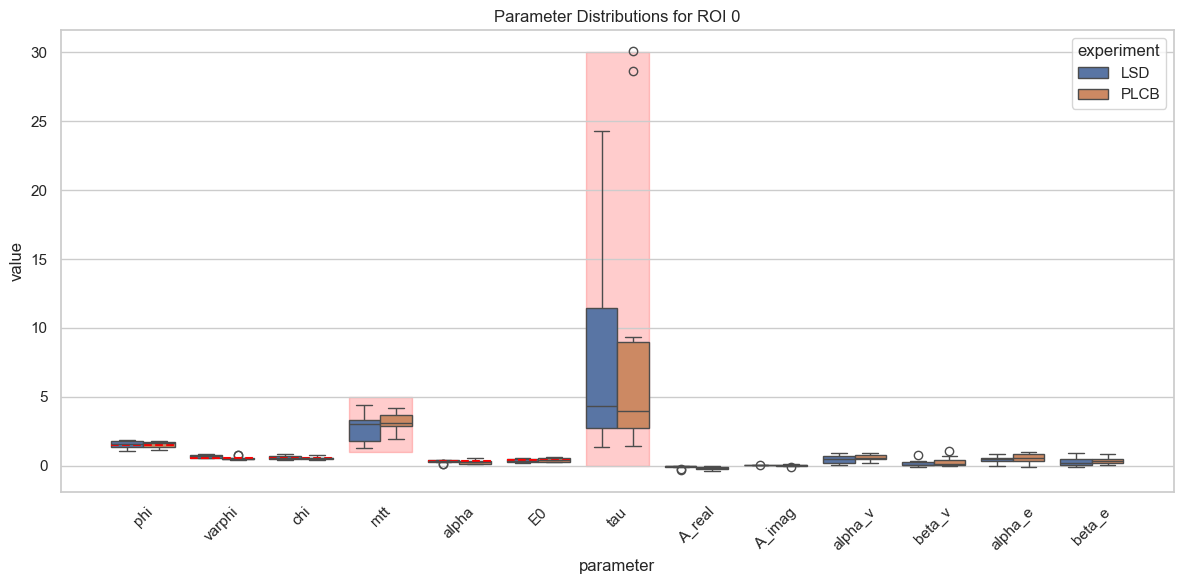

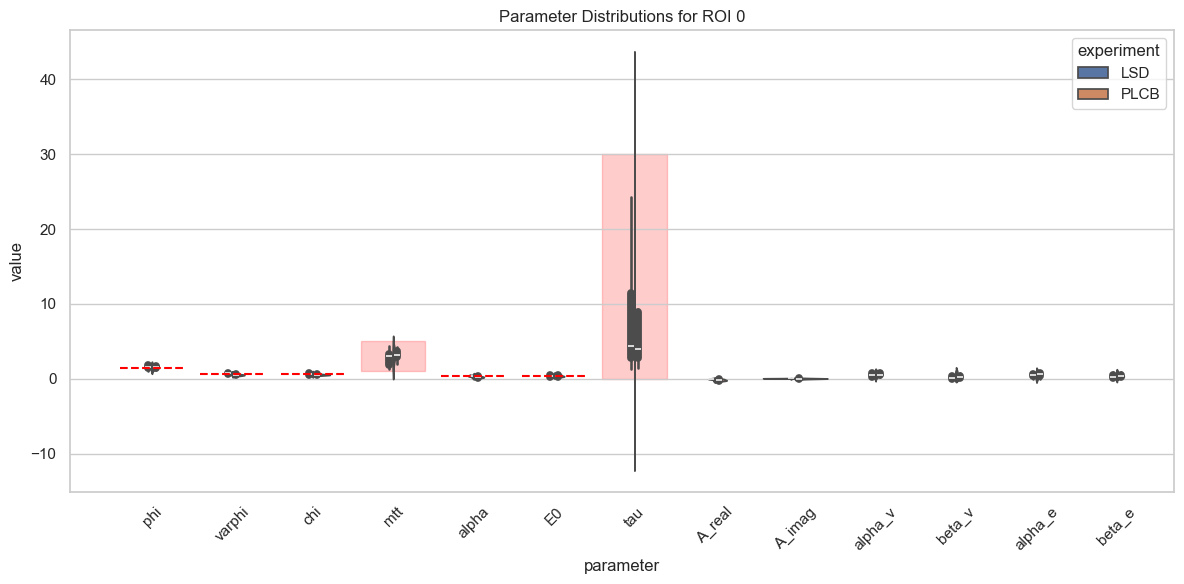

roi parameter  mean_diff   std_diff   cohen_d effect_size    t_stat  \
0     0    A_imag   0.025964   0.064918  0.399947       small  1.548987   
1     0    A_real   0.080000   0.139745  0.572472      medium  2.217174   
2     0        E0  -0.030489   0.146452 -0.208186       small -0.806303   
3     0     alpha   0.014248   0.188847  0.075446  very small  0.292202   
4     0   alpha_e  -0.055180   0.408398 -0.135114  very small -0.523296   
5     0   alpha_v  -0.072307   0.402839 -0.179492  very small -0.695171   
6     0    beta_e  -0.080882   0.289600 -0.279290       small -1.081685   
7     0    beta_v  -0.111333   0.347014 -0.320832       small -1.242577   
8     0       chi   0.043727   0.184821  0.236591       small  0.916312   
9     0       mtt  -0.733774   1.310399 -0.559962      medium -2.168724   
10    0       phi  -0.086358   0.402124 -0.214754       small -0.831738   
11    0       tau  -1.949211  14.414677 -0.135224  very small -0.523721   
12    0    varphi   0.109969   0.114393  0.961327       large  3.723204   

     p_value  reject_raw                         interpret_raw  p_fdr_bh  \
0   0.143689       False         not significant, ↑ LSD > PLCB  0.932291   
1   0.043670        True  marginally significant, ↑ LSD > PLCB  0.932291   
2   0.433552       False         not significant, ↓ LSD < PLCB  0.972396   
3   0.774418       False         not significant, ↑ LSD > PLCB  0.986938   
4   0.608952       False         not significant, ↓ LSD < PLCB  0.976126   
5   0.498325       False         not significant, ↓ LSD < PLCB  0.972396   
6   0.297673       False         not significant, ↓ LSD < PLCB  0.932291   
7   0.234435       False         not significant, ↓ LSD < PLCB  0.932291   
8   0.375018       False         not significant, ↑ LSD > PLCB  0.958983   
9   0.047818        True  marginally significant, ↓ LSD < PLCB  0.932291   
10  0.419518       False         not significant, ↓ LSD < PLCB  0.972396   
11  0.608664       False         not significant, ↓ LSD < PLCB  0.976126   
12  0.002271        True             significant, ↑ LSD > PLCB  0.529370   

    reject_fdr_bh               interpret_fdr_bh  p_bonferroni  \
0           False  not significant, ↑ LSD > PLCB           1.0   
1           False  not significant, ↑ LSD > PLCB           1.0   
2           False  not significant, ↓ LSD < PLCB           1.0   
3           False  not significant, ↑ LSD > PLCB           1.0   
4           False  not significant, ↓ LSD < PLCB           1.0   
5           False  not significant, ↓ LSD < PLCB           1.0   
6           False  not significant, ↓ LSD < PLCB           1.0   
7           False  not significant, ↓ LSD < PLCB           1.0   
8           False  not significant, ↑ LSD > PLCB           1.0   
9           False  not significant, ↓ LSD < PLCB           1.0   
10          False  not significant, ↓ LSD < PLCB           1.0   
11          False  not significant, ↓ LSD < PLCB           1.0   
12          False  not significant, ↑ LSD > PLCB           1.0   

    reject_bonferroni           interpret_bonferroni  p_holm  reject_holm  \
0               False  not significant, ↑ LSD > PLCB     1.0        False   
1               False  not significant, ↑ LSD > PLCB     1.0        False   
2               False  not significant, ↓ LSD < PLCB     1.0        False   
3               False  not significant, ↑ LSD > PLCB     1.0        False   
4               False  not significant, ↓ LSD < PLCB     1.0        False   
5               False  not significant, ↓ LSD < PLCB     1.0        False   
6               False  not significant, ↓ LSD < PLCB     1.0        False   
7               False  not significant, ↓ LSD < PLCB     1.0        False   
8               False  not significant, ↑ LSD > PLCB     1.0        False   
9               False  not significant, ↓ LSD < PLCB     1.0        False   
10              False  not significant, ↓ LSD < PLCB     1.0        False   
11              False  not significant,

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("spdcm_all_data.csv")

# Filter to only the parameters of interest
params = ['phi', 'varphi', 'chi', 'mtt', 'alpha', 'E0',
          'tau', 'A_real', 'A_imag',
          'alpha_v', 'beta_v', 'alpha_e', 'beta_e']

df = df[df["parameter"].isin(params)]

# Pivot so each parameter is a separate column
df_pivot = df.pivot_table(
    index=["subject", "roi", "experiment"],
    columns="parameter",
    values="value"
).reset_index()

literature_values = {
    'phi': 1.5,
    'varphi': 0.6,
    'chi': 0.6,
    'mtt': (1.0, 5.0),
    'tau': (0, 30),
    'alpha': 0.32,
    'E0': 0.4
}

chosen_roi = 0

# Filter for the chosen ROI
roi_data = df_pivot[df_pivot["roi"] == chosen_roi]

# Melt the data to long format for plotting
roi_melted = roi_data.melt(
    id_vars=["subject", "experiment"],
    value_vars=[col for col in roi_data.columns if col not in ["subject", "roi", "experiment"]],
    var_name="parameter",
    value_name="value"
)

selected_subjects = [1, 2, 3, 4, 6, 10, 11, 12, 19, 20]
selected_parameters = ['phi', 'varphi', 'chi', 'mtt', 'alpha', 'E0',
                       'tau', 'A_real', 'A_imag',
                       'alpha_v', 'beta_v', 'alpha_e', 'beta_e']


roi_melted = roi_melted[
    roi_melted["subject"].isin(selected_subjects) &
    roi_melted["parameter"].isin(selected_parameters)
    ]
roi_melted["parameter"] = pd.Categorical(
    roi_melted["parameter"],
    categories=selected_parameters,
    ordered=True
)


def add_literature_references(ax, parameters, bar_width=0.8):
    """
    Adds red lines or shaded areas only to the correct x-position for each parameter column.
    """
    xticks = ax.get_xticks()
    xlabels = [t.get_text() for t in ax.get_xticklabels()]
    param_to_x = dict(zip(xlabels, xticks))

    for param in parameters:
        if param not in literature_values or param not in param_to_x:
            continue

        x = param_to_x[param]
        half_width = bar_width / 2

        ref = literature_values[param]
        if isinstance(ref, tuple):
            ax.fill_between(
                [x - half_width, x + half_width],
                ref[0], ref[1],
                color='red', alpha=0.2, zorder=0
            )
        else:
            ax.plot(
                [x - half_width, x + half_width],
                [ref, ref],
                color='red', linestyle='--', linewidth=1.5
            )


# Bar Plot 
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=roi_melted, x="parameter", y="value", hue="experiment", errorbar="sd")
add_literature_references(ax, roi_melted["parameter"].unique())
plt.title(f"Mean Parameter Values for ROI {chosen_roi} (PLCB vs LSD)")
plt.ylabel("Parameter Value")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Box Plot 
plt.figure(figsize=(12, 6))
ax = sns.boxplot(data=roi_melted, x="parameter", y="value", hue="experiment")
add_literature_references(ax, roi_melted["parameter"].unique())
plt.title(f"Parameter Distributions for ROI {chosen_roi}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot 3: Violin Plot 
plt.figure(figsize=(12, 6))
ax = sns.violinplot(data=roi_melted, x="parameter", y="value", hue="experiment", split=True)
add_literature_references(ax, roi_melted["parameter"].unique())
plt.title(f"Parameter Distributions for ROI {chosen_roi}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

ttest_results = pd.read_csv("spdcm_roi_ttest_results.csv")

# Filter for the chosen ROI
ttest_for_roi = ttest_results[ttest_results["roi"] == chosen_roi]

ttest_for_roi

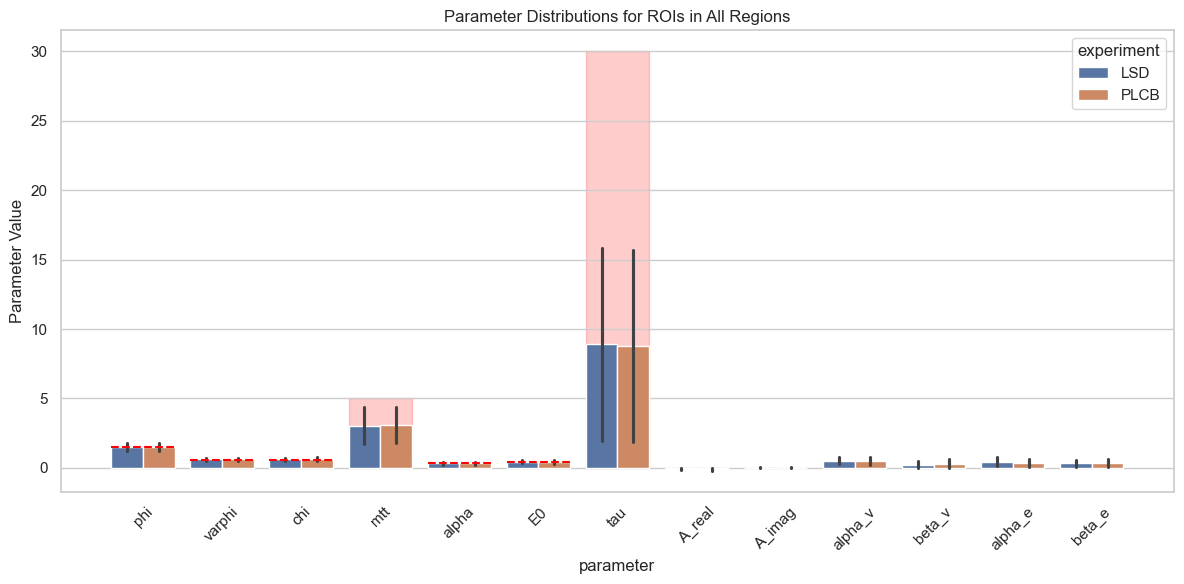

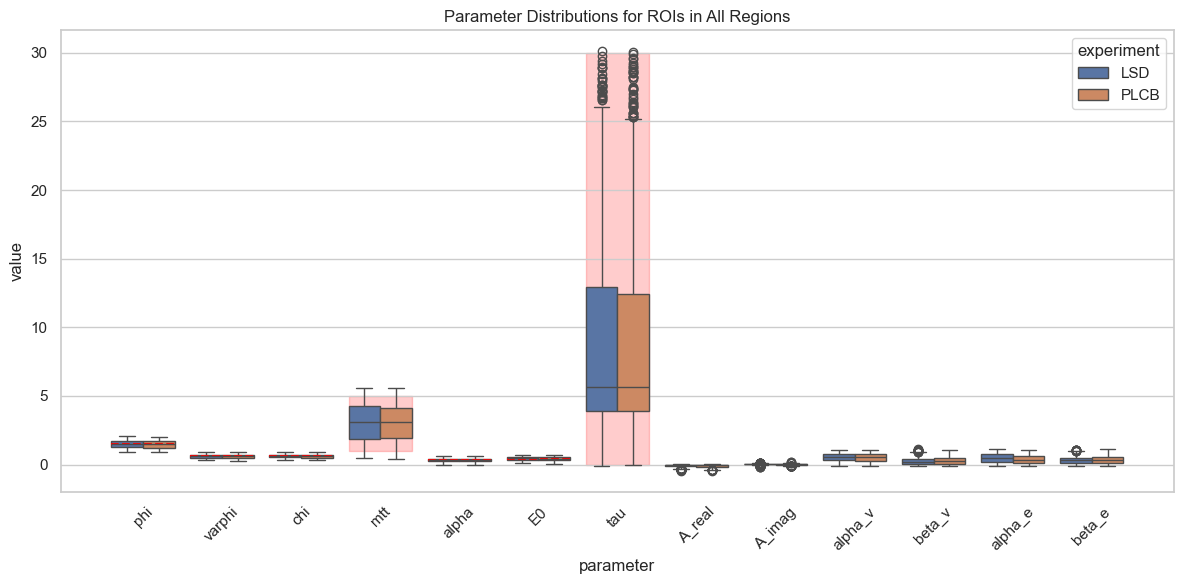

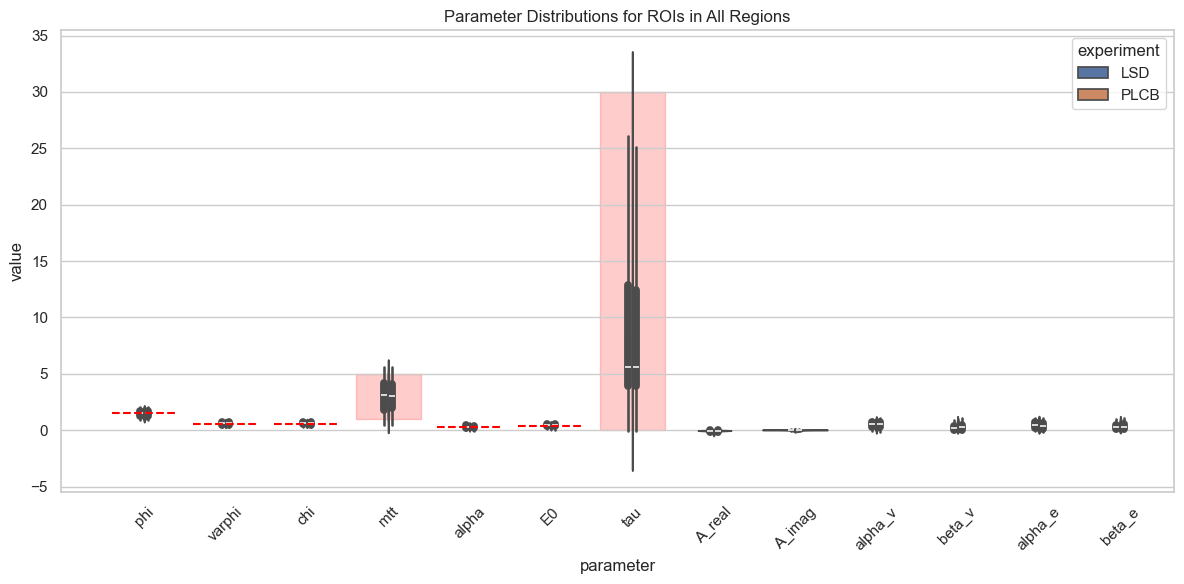

network parameter  mean_diff  std_diff   cohen_d effect_size  \
0   All Regions       phi   0.002019  0.197039  0.010246  very small   
1   All Regions     alpha   0.030880  0.093236  0.331205       small   
2   All Regions       mtt   0.699568  1.319242  0.530280      medium   
3   All Regions    beta_e  -0.062221  0.169667 -0.366725       small   
4   All Regions       chi  -0.026222  0.097039 -0.270224       small   
5   All Regions       tau   0.356107  5.224125  0.068166  very small   
6   All Regions   alpha_v   0.032599  0.169352  0.192493  very small   
7   All Regions    beta_v  -0.042065  0.203794 -0.206407       small   
8   All Regions   alpha_e   0.010467  0.256532  0.040803  very small   
9   All Regions    varphi  -0.004621  0.112692 -0.041008  very small   
10  All Regions        E0   0.014090  0.105257  0.133861  very small   

      t_stat   p_value  reject_raw                  interpret_raw  p_fdr_bh  \
0   0.039684  0.968905       False  not significant, ↑ LSD > PLCB  0.990267   
1   1.282753  0.220410       False  not significant, ↑ LSD > PLCB  0.806846   
2   2.053766  0.059169       False  not significant, ↑ LSD > PLCB  0.707971   
3  -1.420318  0.177401       False  not significant, ↓ LSD < PLCB  0.805621   
4  -1.046573  0.313030       False  not significant, ↓ LSD < PLCB  0.806846   
5   0.264005  0.795622       False  not significant, ↑ LSD > PLCB  0.962661   
6   0.745520  0.468290       False  not significant, ↑ LSD > PLCB  0.823833   
7  -0.799410  0.437406       False  not significant, ↓ LSD < PLCB  0.820641   
8   0.158028  0.876691       False  not significant, ↑ LSD > PLCB  0.964360   
9  -0.158825  0.876075       False  not significant, ↓ LSD < PLCB  0.964360   
10  0.518440  0.612248       False  not significant, ↑ LSD > PLCB  0.882153   

    reject_fdr_bh               interpret_fdr_bh  p_bonferroni  \
0           False  not significant, ↑ LSD > PLCB           1.0   
1           False  not significant, ↑ LSD > PLCB           1.0   
2           False  not significant, ↑ LSD > PLCB           1.0   
3           False  not significant, ↓ LSD < PLCB           1.0   
4           False  not significant, ↓ LSD < PLCB           1.0   
5           False  not significant, ↑ LSD > PLCB           1.0   
6           False  not significant, ↑ LSD > PLCB           1.0   
7           False  not significant, ↓ LSD < PLCB           1.0   
8           False  not significant, ↑ LSD > PLCB           1.0   
9           False  not significant, ↓ LSD < PLCB           1.0   
10          False  not significant, ↑ LSD > PLCB           1.0   

    reject_bonferroni           interpret_bonferroni  p_holm  reject_holm  \
0               False  not significant, ↑ LSD > PLCB     1.0        False   
1               False  not significant, ↑ LSD > PLCB     1.0        False   
2               False  not significant, ↑ LSD > PLCB     1.0        False   
3               False  not significant, ↓ LSD < PLCB     1.0        False   
4               False  not significant, ↓ LSD < PLCB     1.0        False   
5               False  not significant, ↑ LSD > PLCB     1.0        False   
6               False  not significant, ↑ LSD > PLCB     1.0        False   
7               False  not significant, ↓ LSD < PLCB     1.0        False   
8               False  not significant, ↑ LSD > PLCB     1.0        False   
9               False  not significant, ↓ LSD < PLCB     1.0        False   
10              False  not significant, ↑ LSD > PLCB     1.0        False   

                   interpret_holm  
0   not significant, ↑ LSD > PLCB  
1   not significant, ↑ LSD > PLCB  
2   not significant, ↑ LSD > PLCB  
3   not significant, ↓ LSD < PLCB  
4   not significant, ↓ LSD < PLCB  
5   not significant, ↑ LSD > PLCB  
6   not significant, ↑ LSD > PLCB  
7   not significant, ↓ LSD < PLCB  
8   not significant, ↑ LSD > PLCB  
9   not significant, ↓ LSD < PLCB  
10  not significant, ↑ LSD > PLCB

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("spdcm_all_data.csv")

network_rois = {
    "All Regions": list(range(100)), 
    "LH Visual": list(range(0, 9)),
    "RH Visual": list(range(50, 58)),
    "LH Somatomotor": list(range(9, 15)),
    "RH Somatomotor": list(range(58, 66)),
    "LH Dorsal Attention": list(range(15, 23)),
    "RH Dorsal Attention": list(range(66, 72)),
    "LH Salience/Ventral Attention": list(range(23, 30)),
    "RH Salience/Ventral Attention": list(range(73, 77)),
    "LH Limbic": list(range(30, 33)),
    "RH Limbic": list(range(78, 80)),
    "LH Control": list(range(33, 37)),
    "RH Control": list(range(80, 88)),
    "LH Default Mode": list(range(37, 50)),
    "RH Default Mode": list(range(89, 100))
}

selected_network = "All Regions"
selected_rois = network_rois[selected_network]

df = df[df["roi"].isin(selected_rois)]

params = ['phi', 'varphi', 'chi', 'mtt', 'alpha', 'E0',
          'tau', 'A_real', 'A_imag',
          'alpha_v', 'beta_v', 'alpha_e', 'beta_e']

df = df[df["parameter"].isin(params)]

# Pivot to wide format for analysis
df_pivot = df.pivot_table(
    index=["subject", "roi", "experiment"],
    columns="parameter",
    values="value"
).reset_index()

# Melt for Seaborn plotting
roi_melted = df_pivot.melt(
    id_vars=["subject", "experiment", "roi"],
    value_vars=[col for col in df_pivot.columns if col not in ["subject", "roi", "experiment"]],
    var_name="parameter",
    value_name="value"
)

selected_subjects = [1, 2, 3, 4, 6, 10, 11, 12, 19, 20]
selected_parameters = ['phi', 'varphi', 'chi', 'mtt', 'alpha', 'E0', 'tau', 'A_real','A_imag','alpha_v', 'beta_v', 'alpha_e', 'beta_e']


roi_melted = roi_melted[
    roi_melted["subject"].isin(selected_subjects) &
    roi_melted["parameter"].isin(selected_parameters)
    ]
roi_melted["parameter"] = pd.Categorical(
    roi_melted["parameter"],
    categories=selected_parameters,
    ordered=True
)

literature_values = {
    'phi': 1.5,
    'varphi': 0.6,
    'chi': 0.6,
    'mtt': (1.0, 5.0),
    'tau': (0, 30),
    'alpha': 0.32,
    'E0': 0.4
}

def add_literature_references(ax, parameters, bar_width=0.8):
    """
    Adds red lines or shaded areas only to the correct x-position for each parameter column.
    """
    xticks = ax.get_xticks()
    xlabels = [t.get_text() for t in ax.get_xticklabels()]
    param_to_x = dict(zip(xlabels, xticks))

    for param in parameters:
        if param not in literature_values or param not in param_to_x:
            continue

        x = param_to_x[param]
        half_width = bar_width / 2

        ref = literature_values[param]
        if isinstance(ref, tuple):
            ax.fill_between(
                [x - half_width, x + half_width],
                ref[0], ref[1],
                color='red', alpha=0.2, zorder=0
            )
        else:
            ax.plot(
                [x - half_width, x + half_width],
                [ref, ref],
                color='red', linestyle='--', linewidth=1.5
            )


# Bar Plot 
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=roi_melted, x="parameter", y="value", hue="experiment", errorbar="sd")
add_literature_references(ax, roi_melted["parameter"].unique())
plt.title(f"Parameter Distributions for ROIs in {selected_network}")
plt.ylabel("Parameter Value")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Box Plot
plt.figure(figsize=(12, 6))
ax = sns.boxplot(data=roi_melted, x="parameter", y="value", hue="experiment")
add_literature_references(ax, roi_melted["parameter"].unique())
plt.title(f"Parameter Distributions for ROIs in {selected_network}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Violin Plot 
plt.figure(figsize=(12, 6))
ax = sns.violinplot(data=roi_melted, x="parameter", y="value", hue="experiment", split=True)
add_literature_references(ax, roi_melted["parameter"].unique())
plt.title(f"Parameter Distributions for ROIs in {selected_network}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

ttest_df = pd.read_csv("spdcm_network_ttest_results.csv")
ttest_filtered = ttest_df[ttest_df["network"] == selected_network]
ttest_filtered

In [63]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_1samp
from statsmodels.stats.multitest import multipletests

sns.set(style="whitegrid")

df = pd.read_csv("spdcm_all_data.csv")

# Define parameters of interest
params = ["phi", "varphi", "chi", "mtt", "tau", "alpha", "E0", "A_real", "A_imag", "alpha_v", "beta_v", "alpha_e", "beta_e"]

# Define networks and associated ROI indices
network_rois = {
    "All Regions": list(range(100)),
    "LH Visual": list(range(0, 9)),
    "RH Visual": list(range(50, 58)),
    "LH Somatomotor": list(range(9, 15)),
    "RH Somatomotor": list(range(58, 66)),
    "LH Dorsal Attention": list(range(15, 23)),
    "RH Dorsal Attention": list(range(66, 72)),
    "LH Salience/Ventral Attention": list(range(23, 30)),
    "RH Salience/Ventral Attention": list(range(73, 77)),
    "LH Limbic": list(range(30, 33)),
    "RH Limbic": list(range(78, 80)),
    "LH Control": list(range(33, 37)),
    "RH Control": list(range(80, 88)),
    "LH Default Mode": list(range(37, 50)),
    "RH Default Mode": list(range(89, 100))
}

# Map ROIs to networks
roi_to_network = {}
for net, rois in network_rois.items():
    for roi in rois:
        roi_to_network[roi] = net

df["network"] = df["roi"].map(roi_to_network)

# Group and average per subject/network/condition
agg_df = df[df["parameter"].isin(params)].groupby(
    ["subject", "network", "experiment", "parameter"]
)["value"].mean().reset_index()

# Run one-sample t-tests per (network, parameter)
results = []

from scipy.stats import ttest_rel

results = []

for net in agg_df["network"].unique():
    for param in params:
        # Get data for PLCB and LSD
        lsd_vals = agg_df[(agg_df["network"] == net) & (agg_df["parameter"] == param) & (agg_df["experiment"] == "LSD")]
        plcb_vals = agg_df[(agg_df["network"] == net) & (agg_df["parameter"] == param) & (agg_df["experiment"] == "PLCB")]

        # Merge on subject to ensure matched pairs
        merged = pd.merge(lsd_vals, plcb_vals, on="subject", suffixes=("_LSD", "_PLCB"))

        if len(merged) < 3:
            continue

        diff = merged["value_LSD"] - merged["value_PLCB"]
        t_stat, p_val = ttest_rel(merged["value_LSD"], merged["value_PLCB"])
        mean_diff = diff.mean()
        std_diff = diff.std(ddof=1)
        cohen_d = mean_diff / std_diff if std_diff != 0 else np.nan

        results.append({
            "network": net,
            "parameter": param,
            "mean_diff": mean_diff,
            "std_diff": std_diff,
            "cohen_d": cohen_d,
            "t_stat": t_stat,
            "p_value": p_val
        })

results_df = pd.DataFrame(results)

# Apply FDR, Bonferroni, Holm
pvals = results_df["p_value"].values
rej_fdr, p_fdr, _, _ = multipletests(pvals, method="fdr_bh")
rej_bonf, p_bonf, _, _ = multipletests(pvals, method="bonferroni")
rej_holm, p_holm, _, _ = multipletests(pvals, method="holm")

# Add to DataFrame
results_df["p_fdr_bh"] = p_fdr
results_df["reject_fdr_bh"] = rej_fdr
results_df["p_bonferroni"] = p_bonf
results_df["reject_bonferroni"] = rej_bonf
results_df["p_holm"] = p_holm
results_df["reject_holm"] = rej_holm
results_df["reject_raw"] = results_df["p_value"] < 0.05

def interpret_delta(p, mean):
    direction = "↑ LSD > PLCB" if mean > 0 else "↓ LSD < PLCB"
    if p < 0.001:
        return f"highly significant, {direction}"
    elif p < 0.01:
        return f"significant, {direction}"
    elif p < 0.05:
        return f"marginally significant, {direction}"
    else:
        return f"not significant, {direction}"


def interpret_p(p):
    if p < 0.001:
        return "highly significant"
    elif p < 0.01:
        return "significant"
    elif p < 0.05:
        return "marginally significant"
    else:
        return "not significant"

def interpret_result(p, mean, ref):
    direction = "↑ above ref" if mean > ref else "↓ below ref"
    return f"{interpret_p(p)}, {direction}"

# Add interpretation based on mean_diff
results_df["interpret_raw"] = results_df.apply(lambda row: interpret_delta(row["p_value"], row["mean_diff"]), axis=1)
results_df["interpret_fdr_bh"] = results_df.apply(lambda row: interpret_delta(row["p_fdr_bh"], row["mean_diff"]), axis=1)
results_df["interpret_bonferroni"] = results_df.apply(lambda row: interpret_delta(row["p_bonferroni"], row["mean_diff"]), axis=1)
results_df["interpret_holm"] = results_df.apply(lambda row: interpret_delta(row["p_holm"], row["mean_diff"]), axis=1)

results_df = results_df[[
    "network", "parameter", "mean_diff", "std_diff", "cohen_d", "t_stat",
    "p_value", "reject_raw", "interpret_raw",
    "p_fdr_bh", "reject_fdr_bh", "interpret_fdr_bh",
    "p_bonferroni", "reject_bonferroni", "interpret_bonferroni",
    "p_holm", "reject_holm", "interpret_holm"
]]


results_df.sort_values("network", inplace=True)
results_df


network parameter  mean_diff  std_diff   cohen_d    t_stat   p_value  \
0    All Regions       phi   0.002019  0.197039  0.010246  0.039684  0.968905   
12   All Regions    beta_e  -0.062221  0.169667 -0.366725 -1.420318  0.177401   
11   All Regions   alpha_e   0.010467  0.256532  0.040803  0.158028  0.876691   
10   All Regions    beta_v  -0.042065  0.203794 -0.206407 -0.799410  0.437406   
8    All Regions    A_imag   0.005154  0.034258  0.150438  0.582644  0.569399   
..           ...       ...        ...       ...       ...       ...       ...   
183    RH Visual    varphi   0.013723  0.051533  0.266300  1.031374  0.319855   
182    RH Visual       phi   0.001060  0.098778  0.010732  0.041566  0.967432   
193    RH Visual   alpha_e  -0.025948  0.194099 -0.133684 -0.517755  0.612713   
187    RH Visual     alpha   0.003301  0.049381  0.066853  0.258920  0.799465   
194    RH Visual    beta_e  -0.024835  0.152288 -0.163081 -0.631610  0.537819   

     reject_raw                  interpret_raw  p_fdr_bh  reject_fdr_bh  \
0         False  not significant, ↑ LSD > PLCB  0.992623          False   
12        False  not significant, ↓ LSD < PLCB  0.809914          False   
11        False  not significant, ↑ LSD > PLCB  0.965846          False   
10        False  not significant, ↓ LSD < PLCB  0.812826          False   
8         False  not significant, ↑ LSD > PLCB  0.880931          False   
..          ...                            ...       ...            ...   
183       False  not significant, ↑ LSD > PLCB  0.809914          False   
182       False  not significant, ↑ LSD > PLCB  0.992623          False   
193       False  not significant, ↓ LSD < PLCB  0.886736          False   
187       False  not significant, ↑ LSD > PLCB  0.962661          False   
194       False  not significant, ↓ LSD < PLCB  0.862442          False   

                  interpret_fdr_bh  p_bonferroni  reject_bonferroni  \
0    not significant, ↑ LSD > PLCB           1.0              False   
12   not significant, ↓ LSD < PLCB           1.0              False   
11   not significant, ↑ LSD > PLCB           1.0              False   
10   not significant, ↓ LSD < PLCB           1.0              False   
8    not significant, ↑ LSD > PLCB           1.0              False   
..                             ...           ...                ...   
183  not significant, ↑ LSD > PLCB           1.0              False   
182  not significant, ↑ LSD > PLCB           1.0              False   
193  not significant, ↓ LSD < PLCB           1.0              False   
187  not significant, ↑ LSD > PLCB           1.0              False   
194  not significant, ↓ LSD < PLCB           1.0              False   

              interpret_bonferroni  p_holm  reject_holm  \
0    not significant, ↑ LSD > PLCB     1.0        False   
12   not significant, ↓ LSD < PLCB     1.0        False   
11   not significant, ↑ LSD > PLCB     1.0        False   
10   not significant, ↓ LSD < PLCB     1.0        False   
8    not significant, ↑ LSD > PLCB     1.0        False   
..                             ...     ...          ...   
183  not significant, ↑ LSD > PLCB     1.0        False   
182  not significant, ↑ LSD > PLCB     1.0        False   
193  not significant, ↓ LSD < PLCB     1.0        False   
187  not significant, ↑ LSD > PLCB     1.0        False   
194  not significant, ↓ LSD < PLCB     1.0        False   

                    interpret_holm  
0    not significant, ↑ LSD > PLCB  
12   not significant, ↓ LSD < PLCB  
11   not significant, ↑ LSD > PLCB  
10   not significant, ↓ LSD < PLCB  
8    not significant, ↑ LSD > PLCB  
..                             ...  
183  not significant, ↑ LSD > PLCB  
182  not significant, ↑ LSD > PLCB  
193  not significant, ↓ LSD < PLCB  
187  not significant, ↑ LSD > PLCB  
194  not significant, ↓ LSD < PLCB  

[195 rows x 18 columns]

In [64]:
# Filter rows where raw p-value is not significant
sig = results_df[results_df["p_value"] <= 0.05].copy()

# Optional: sort for easier inspection
sig.sort_values("network", ascending=False, inplace=True)

# Display or export
sig

network parameter  mean_diff  std_diff   cohen_d  \
185                      RH Visual       mtt   0.243695  0.438877  0.555270   
180                 RH Somatomotor   alpha_e   0.125661  0.212542  0.591228   
155                      RH Limbic    beta_e  -0.142969  0.228674 -0.625207   
134            RH Dorsal Attention       tau  -2.648070  4.278532 -0.618920   
122                RH Default Mode     alpha  -0.030530  0.050513 -0.604410   
80                  LH Somatomotor       chi  -0.052327  0.085798 -0.609883   
76   LH Salience/Ventral Attention   alpha_e   0.125736  0.164410  0.764772   
63                       LH Limbic   alpha_e   0.154962  0.235045  0.659286   
48             LH Dorsal Attention   alpha_v   0.068104  0.112293  0.606484   
34                 LH Default Mode    A_imag   0.020721  0.028328  0.731469   

       t_stat   p_value  reject_raw                         interpret_raw  \
185  2.150550  0.049466        True  marginally significant, ↑ LSD > PLCB   
180  2.289817  0.038078        True  marginally significant, ↑ LSD > PLCB   
155 -2.421415  0.029627        True  marginally significant, ↓ LSD < PLCB   
134 -2.397068  0.031043        True  marginally significant, ↓ LSD < PLCB   
122 -2.340869  0.034559        True  marginally significant, ↓ LSD < PLCB   
80  -2.362067  0.033191        True  marginally significant, ↓ LSD < PLCB   
76   2.961949  0.010299        True  marginally significant, ↑ LSD > PLCB   
63   2.553404  0.022965        True  marginally significant, ↑ LSD > PLCB   
48   2.348901  0.034035        True  marginally significant, ↑ LSD > PLCB   
34   2.832967  0.013289        True  marginally significant, ↑ LSD > PLCB   

     p_fdr_bh  reject_fdr_bh               interpret_fdr_bh  p_bonferroni  \
185  0.746321          False  not significant, ↑ LSD > PLCB           1.0   
180  0.746321          False  not significant, ↑ LSD > PLCB           1.0   
155  0.746321          False  not significant, ↓ LSD < PLCB           1.0   
134  0.746321          False  not significant, ↓ LSD < PLCB           1.0   
122  0.746321          False  not significant, ↓ LSD < PLCB           1.0   
80   0.746321          False  not significant, ↓ LSD < PLCB           1.0   
76   0.746321          False  not significant, ↑ LSD > PLCB           1.0   
63   0.746321          False  not significant, ↑ LSD > PLCB           1.0   
48   0.746321          False  not significant, ↑ LSD > PLCB           1.0   
34   0.746321          False  not significant, ↑ LSD > PLCB           1.0   

     reject_bonferroni           interpret_bonferroni  p_holm  reject_holm  \
185              False  not significant, ↑ LSD > PLCB     1.0        False   
180              False  not significant, ↑ LSD > PLCB     1.0        False   
155              False  not significant, ↓ LSD < PLCB     1.0        False   
134              False  not significant, ↓ LSD < PLCB     1.0        False   
122              False  not significant, ↓ LSD < PLCB     1.0        False   
80               False  not significant, ↓ LSD < PLCB     1.0        False   
76               False  not significant, ↑ LSD > PLCB     1.0        False   
63               False  not significant, ↑ LSD > PLCB     1.0        False   
48               False  not significant, ↑ LSD > PLCB     1.0        False   
34               False  not significant, ↑ LSD > PLCB     1.0        False   

                    interpret_holm  
185  not significant, ↑ LSD > PLCB  
180  not significant, ↑ LSD > PLCB  
155  not significant, ↓ LSD < PLCB  
134  not significant, ↓ LSD < PLCB  
122  not significant, ↓ LSD < PLCB  
80   not significant, ↓ LSD < PLCB  
76   not significant, ↑ LSD > PLCB  
63   not significant, ↑ LSD > PLCB  
48   not significant, ↑ LSD > PLCB  
34   not significant, ↑ LSD > PLCB

In [65]:
# Bonferroni 
sig_bonf = results_df[results_df["reject_bonferroni"] == True]
sig_bonf

Empty DataFrame
Columns: [network, parameter, mean_diff, std_diff, cohen_d, t_stat, p_value, reject_raw, interpret_raw, p_fdr_bh, reject_fdr_bh, interpret_fdr_bh, p_bonferroni, reject_bonferroni, interpret_bonferroni, p_holm, reject_holm, interpret_holm]
Index: []

In [66]:
# FDR BH significant
sig_fdr = results_df[results_df["reject_fdr_bh"] == True]
sig_fdr

Empty DataFrame
Columns: [network, parameter, mean_diff, std_diff, cohen_d, t_stat, p_value, reject_raw, interpret_raw, p_fdr_bh, reject_fdr_bh, interpret_fdr_bh, p_bonferroni, reject_bonferroni, interpret_bonferroni, p_holm, reject_holm, interpret_holm]
Index: []

In [67]:
# Holm significant
sig_holm = results_df[results_df["reject_holm"] == True]
sig_holm

Empty DataFrame
Columns: [network, parameter, mean_diff, std_diff, cohen_d, t_stat, p_value, reject_raw, interpret_raw, p_fdr_bh, reject_fdr_bh, interpret_fdr_bh, p_bonferroni, reject_bonferroni, interpret_bonferroni, p_holm, reject_holm, interpret_holm]
Index: []

In [68]:
# Filter where tests show significant difference
consistently_sig = results_df[
    (results_df["reject_raw"] == True) &
    (results_df["reject_fdr_bh"] == True) &
    (results_df["reject_bonferroni"] == True) &
    (results_df["reject_holm"] == True)
]

consistently_sig = consistently_sig.sort_values("network")

consistently_sig


Empty DataFrame
Columns: [network, parameter, mean_diff, std_diff, cohen_d, t_stat, p_value, reject_raw, interpret_raw, p_fdr_bh, reject_fdr_bh, interpret_fdr_bh, p_bonferroni, reject_bonferroni, interpret_bonferroni, p_holm, reject_holm, interpret_holm]
Index: []

/var/folders/0j/8rw9s9dd56v924gjnszhk07m0000gn/T/ipykernel_59120/3548605730.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  annot_data[pval_pivot >= 0.05] = ""  # blank where p is not significant
/var/folders/0j/8rw9s9dd56v924gjnszhk07m0000gn/T/ipykernel_59120/3548605730.py:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot_data = annot_data.applymap(lambda x: f"{x:.2f}" if isinstance(x, float) else "")


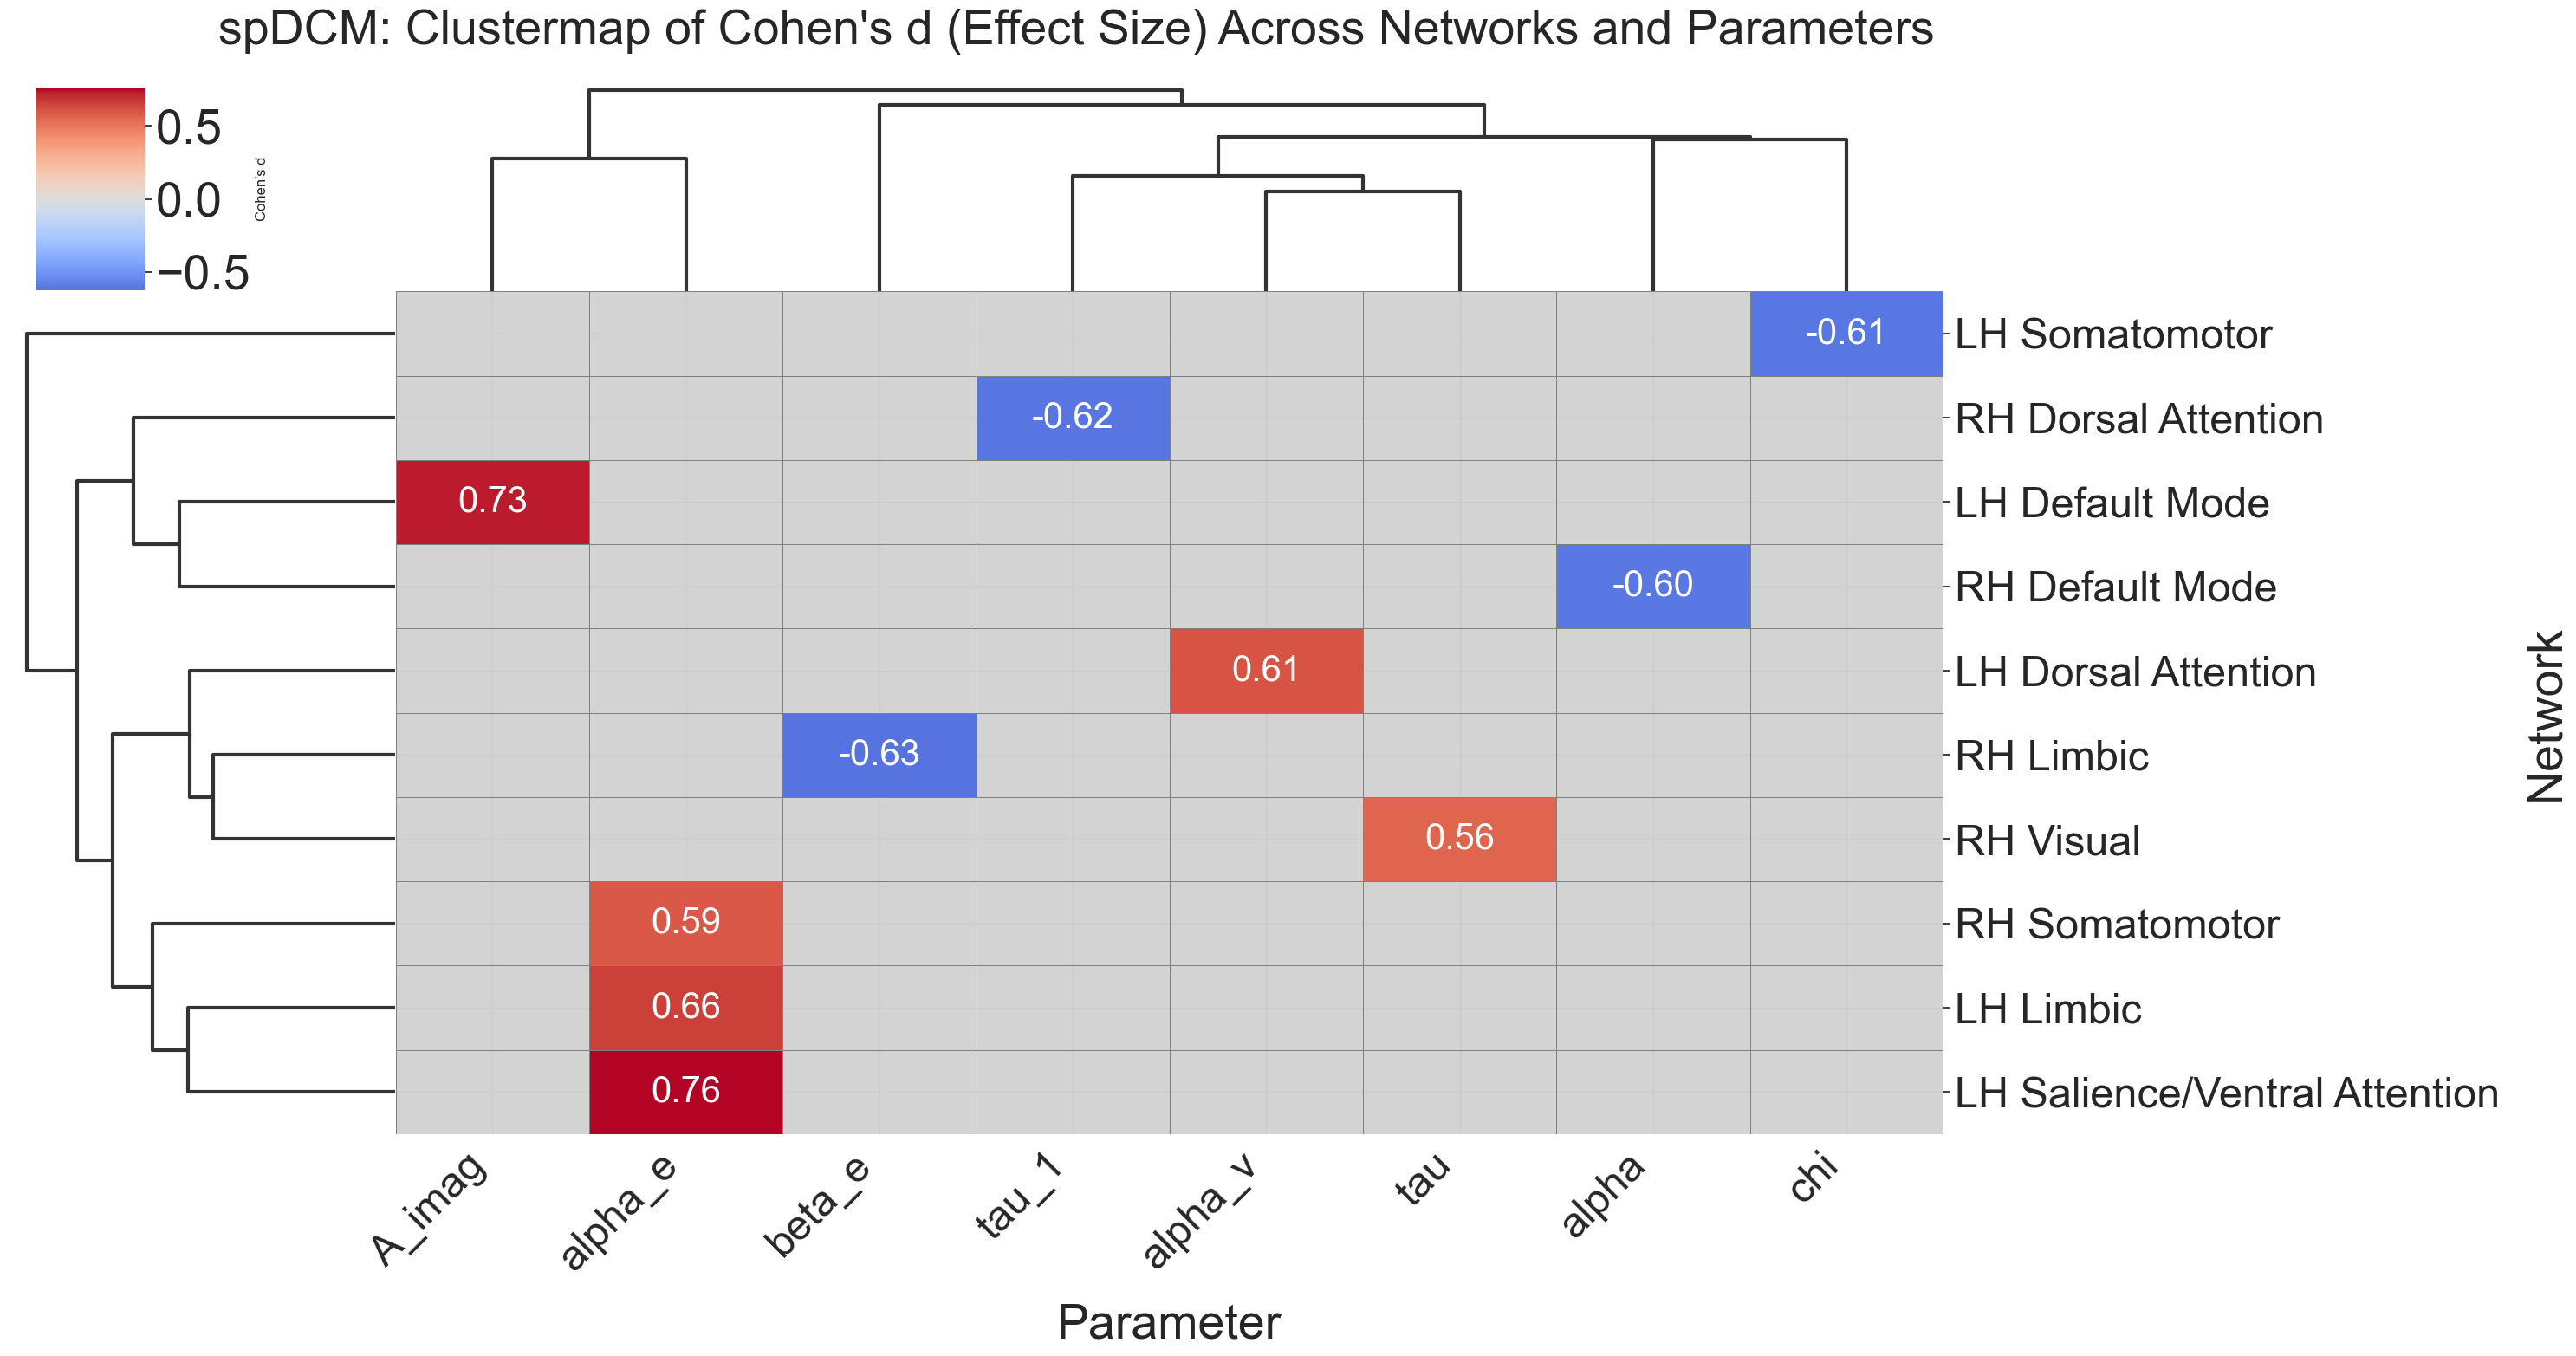


Significant Cohen's d (p < 0.05):
                      network parameter   cohen_d  p_value
LH Salience/Ventral Attention   alpha_e  0.764772 0.010299
              LH Default Mode    A_imag  0.731469 0.013289
                    LH Limbic   alpha_e  0.659286 0.022965
                    RH Limbic    beta_e -0.625207 0.029627
          RH Dorsal Attention     tau_1 -0.618920 0.031043
               LH Somatomotor       chi -0.609883 0.033191
          LH Dorsal Attention   alpha_v  0.606484 0.034035
              RH Default Mode     alpha -0.604410 0.034559
               RH Somatomotor   alpha_e  0.591228 0.038078
                    RH Visual       tau  0.555270 0.049466

Row Dendrogram Linkage (Networks):
   Cluster 1  Cluster 2  Distance  Sample Count
0        7.0        9.0  0.669147           2.0
1        1.0       10.0  0.753968           3.0
2        2.0        3.0  0.760219           2.0
3        0.0        5.0  0.790826           2.0
4        8.0       12.0  0.888677       

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.collections import LineCollection

# Pivot Cohen's d values
net_pivot_d = results_df.pivot(index="network", columns="parameter", values="cohen_d")

# Rename parameters for consistency
rename_map = {"lamb": "lambda", "mtt": "tau", "tau": "tau_1"}
net_pivot_d.rename(columns=rename_map, inplace=True)

# Pivot p-values for significance masking
pval_pivot = results_df.pivot(index="network", columns="parameter", values="p_value")
pval_pivot.rename(columns=rename_map, inplace=True)

# Create annotation DataFrame: only show Cohen's d where p < 0.05
annot_data = net_pivot_d.copy()
annot_data[pval_pivot >= 0.05] = ""  # blank where p is not significant
annot_data = annot_data.applymap(lambda x: f"{x:.2f}" if isinstance(x, float) else "")
mask = pval_pivot >= 0.05

# Identify rows with at least one significant p-value
significant_rows = (pval_pivot < 0.05).any(axis=1)

# Filter pivoted data and annotations
net_pivot_d = net_pivot_d.loc[significant_rows]
pval_pivot = pval_pivot.loc[significant_rows]
annot_data = annot_data.loc[significant_rows]
mask = mask.loc[significant_rows]

# Identify rows with at least one significant p-value
significant_rows = (pval_pivot < 0.05).any(axis=1)

# Identify columns (parameters) with at least one significant p-value
significant_cols = (pval_pivot < 0.05).any(axis=0)

# Filter pivoted data and annotations for significant rows AND columns
net_pivot_d = net_pivot_d.loc[significant_rows, significant_cols]
pval_pivot = pval_pivot.loc[significant_rows, significant_cols]
annot_data = annot_data.loc[significant_rows, significant_cols]
mask = mask.loc[significant_rows, significant_cols]


h_net = sns.clustermap(
    net_pivot_d,
    cmap="coolwarm",
    center=0,
    figsize=(25, 13),
    yticklabels=True,
    xticklabels=True,
    annot=annot_data,
    fmt="",
    annot_kws={"size": 30},
    cbar_kws={"label": "Cohen's d"},
    mask=mask,
    linewidths=0.5,  
    linecolor="gray"  
)

h_net.ax_heatmap.set_facecolor("lightgray")
for ax in [h_net.ax_col_dendrogram, h_net.ax_row_dendrogram]:
    for collection in ax.collections:
        if isinstance(collection, LineCollection):
            collection.set_linewidth(3.0)

h_net.fig.suptitle("spDCM: Clustermap of Cohen's d (Effect Size) Across Networks and Parameters",
                   y=1.05, fontsize=40)
h_net.ax_heatmap.set_xlabel("Parameter", fontsize=40, labelpad=20)
h_net.ax_heatmap.set_ylabel("Network", fontsize=40, labelpad=20)

plt.setp(h_net.ax_heatmap.xaxis.get_majorticklabels(), fontsize=35, rotation=45, ha="right")
plt.setp(h_net.ax_heatmap.yaxis.get_majorticklabels(), fontsize=35)
h_net.cax.tick_params(labelsize=40)

plt.show()

sig_cohen_d = results_df[results_df["p_value"] < 0.05].copy()
sig_cohen_d["parameter"] = sig_cohen_d["parameter"].replace(rename_map)
sig_cohen_d = sig_cohen_d[["network", "parameter", "cohen_d", "p_value"]].sort_values(by="p_value")

print("\nSignificant Cohen's d (p < 0.05):")
print(sig_cohen_d.to_string(index=False))

row_linkage_df = pd.DataFrame(h_net.dendrogram_row.linkage, columns=["Cluster 1", "Cluster 2", "Distance", "Sample Count"])
col_linkage_df = pd.DataFrame(h_net.dendrogram_col.linkage, columns=["Cluster 1", "Cluster 2", "Distance", "Sample Count"])

print("\nRow Dendrogram Linkage (Networks):")
print(row_linkage_df)

print("\nColumn Dendrogram Linkage (Parameters):")
print(col_linkage_df)


/var/folders/0j/8rw9s9dd56v924gjnszhk07m0000gn/T/ipykernel_59120/2034996451.py:24: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot_data = annot_data.applymap(lambda x: f"{x:.2f}" if isinstance(x, float) else "")
/var/folders/0j/8rw9s9dd56v924gjnszhk07m0000gn/T/ipykernel_59120/2034996451.py:33: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot_data = annot_data.applymap(lambda x: f"{x:.2f}" if isinstance(x, float) else "")


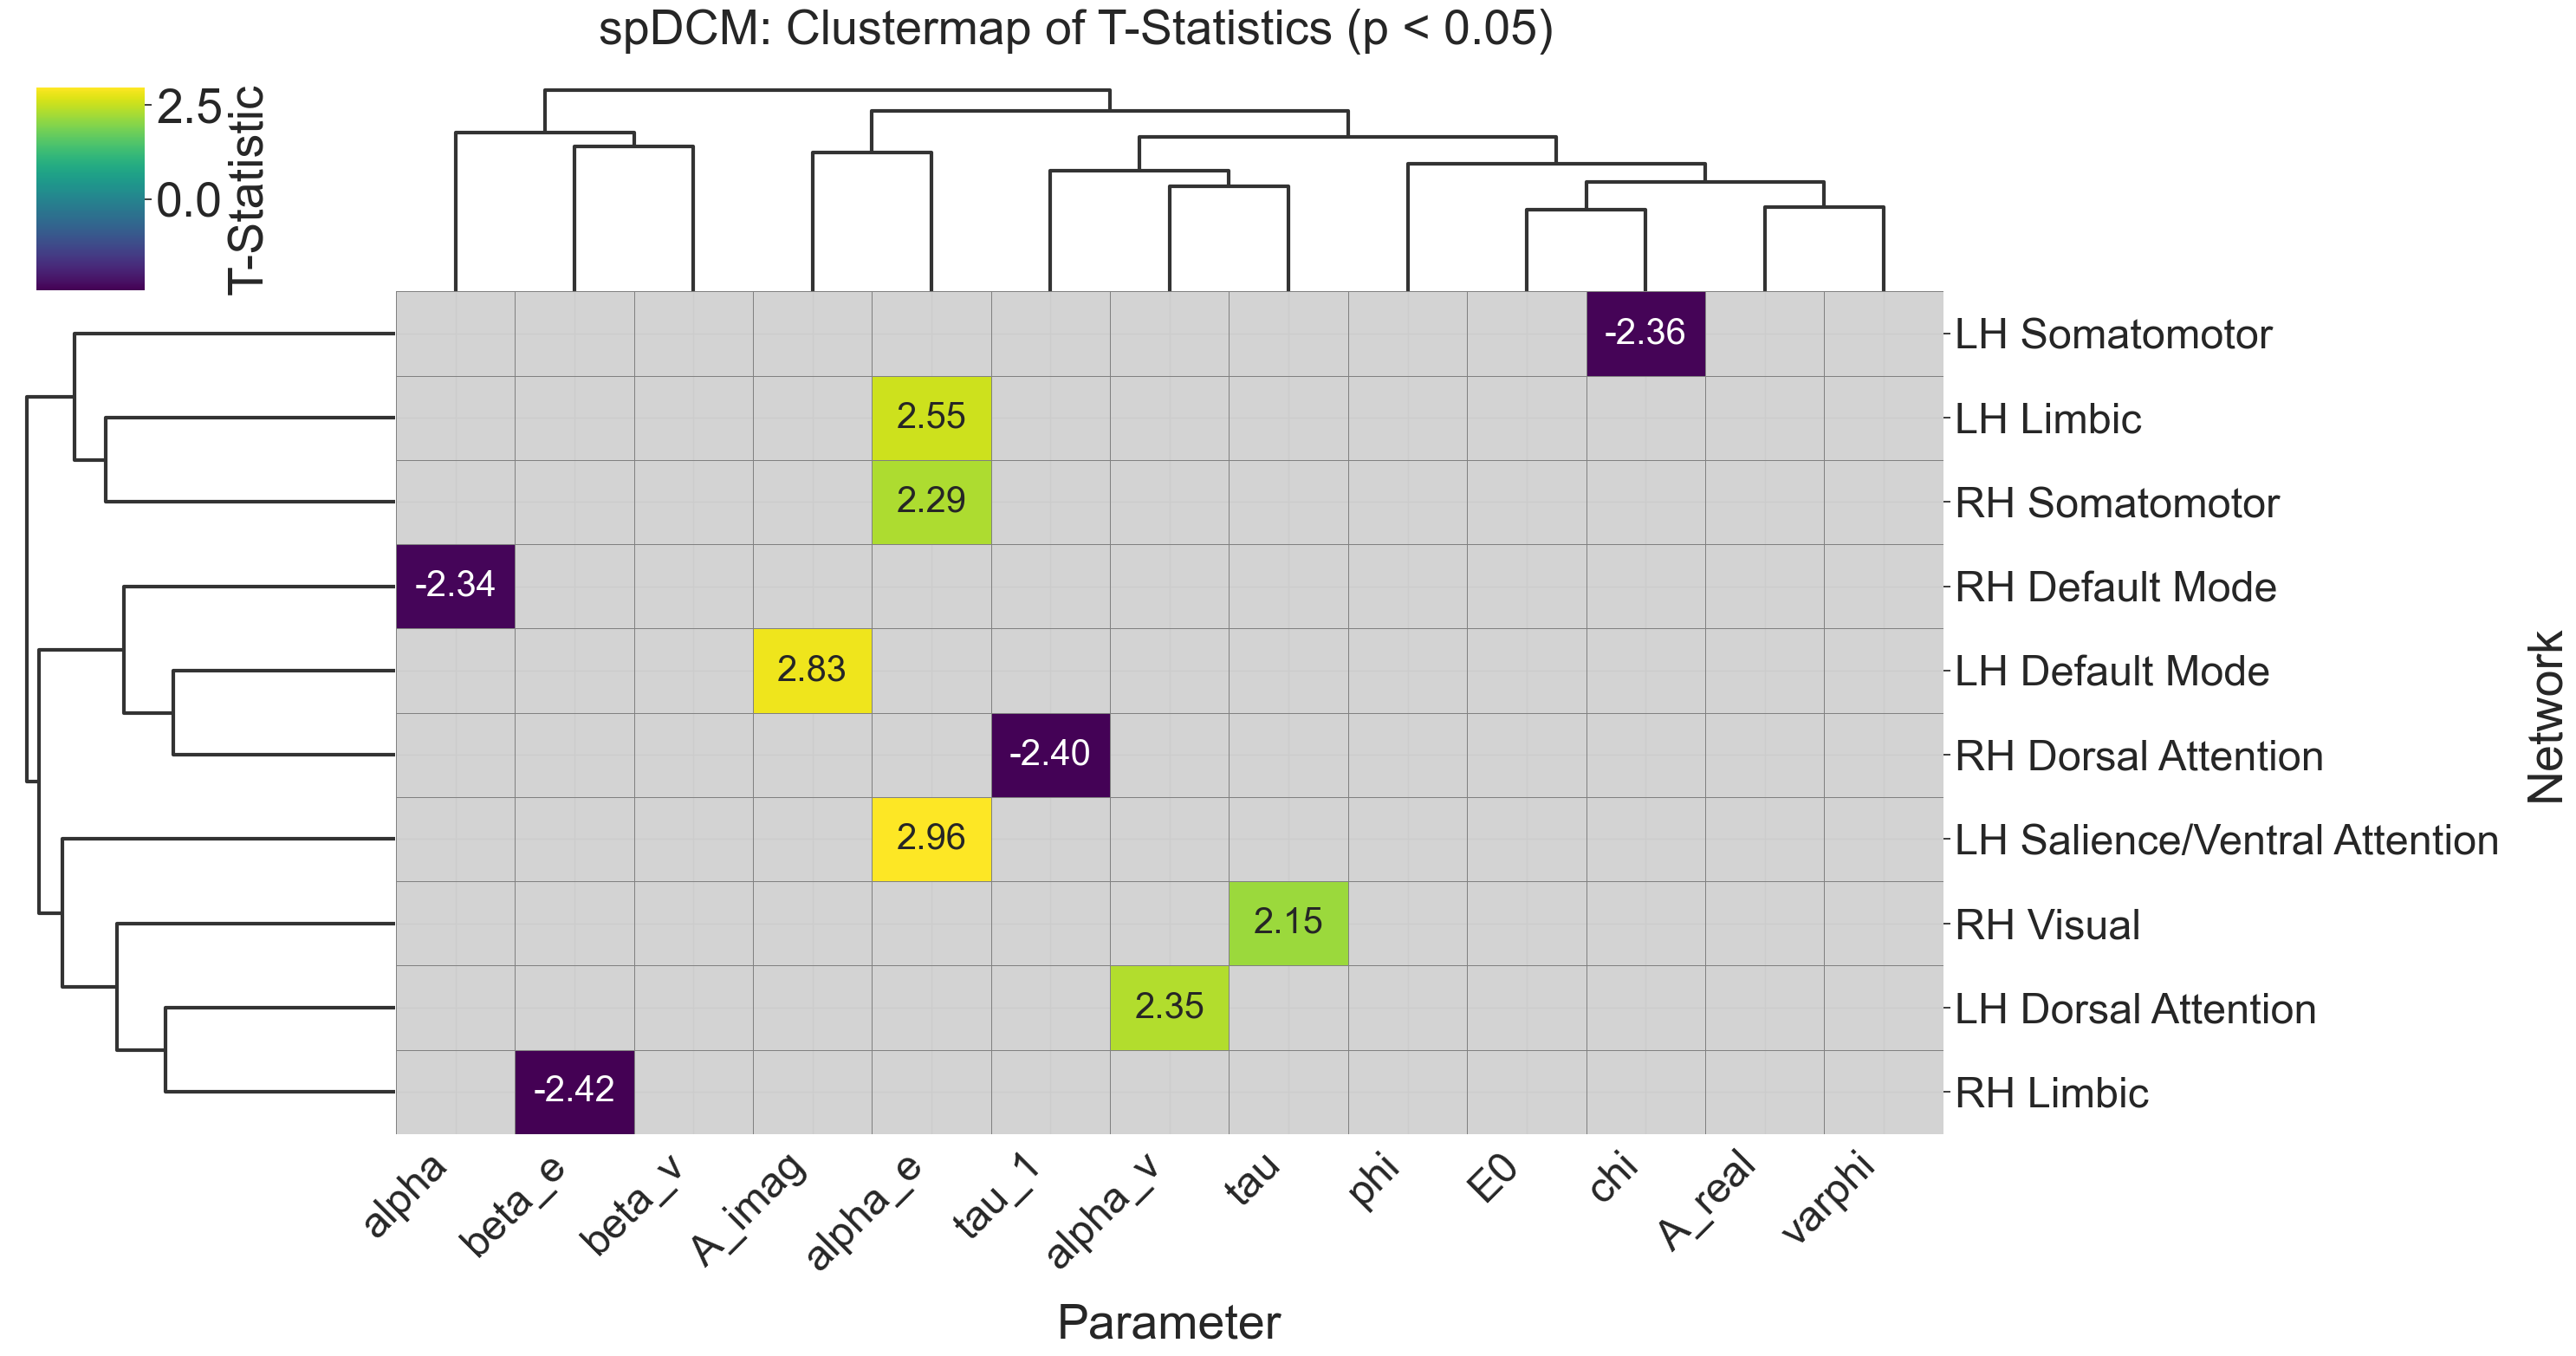


Significant T-Statistics (p < 0.05):
                      network parameter    t_stat  p_value
LH Salience/Ventral Attention   alpha_e  2.961949 0.010299
              LH Default Mode    A_imag  2.832967 0.013289
                    LH Limbic   alpha_e  2.553404 0.022965
                    RH Limbic    beta_e -2.421415 0.029627
          RH Dorsal Attention     tau_1 -2.397068 0.031043
               LH Somatomotor       chi -2.362067 0.033191
          LH Dorsal Attention   alpha_v  2.348901 0.034035
              RH Default Mode     alpha -2.340869 0.034559
               RH Somatomotor   alpha_e  2.289817 0.038078
                    RH Visual       tau  2.150550 0.049466

Row Dendrogram Linkage (Networks):
   Cluster 1  Cluster 2  Distance  Sample Count
0        0.0        6.0  3.303900           2.0
1        1.0        7.0  3.426551           2.0
2        5.0       10.0  4.043881           3.0
3        9.0       11.0  4.143671           3.0
4        2.0        8.0  4.314670    

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.collections import LineCollection

# Filter only significant entries
sig_df = results_df[results_df["p_value"] < 0.05].copy()

# Rename parameters for clarity
rename_map = {"lamb": "lambda", "mtt": "tau", "tau": "tau_1"}
sig_df["parameter"] = sig_df["parameter"].replace(rename_map)


# Pivot full matrix, even including non-significant values
full_df = results_df.copy()
full_df["parameter"] = full_df["parameter"].replace(rename_map)
net_pivot_d = full_df.pivot(index="network", columns="parameter", values="t_stat")

# Create mask for non-significant values
mask = full_df.pivot(index="network", columns="parameter", values="p_value") >= 0.05

# Create annotation: show t-stat only for significant entries
annot_data = net_pivot_d.copy()
annot_data = annot_data.applymap(lambda x: f"{x:.2f}" if isinstance(x, float) else "")

# Drop rows (networks) with no significant values
sig_networks = mask.index[~mask.all(axis=1)]  # keep rows with at least one False (i.e., p < 0.05)
net_pivot_d = net_pivot_d.loc[sig_networks]
mask = mask.loc[sig_networks]
annot_data = annot_data.loc[sig_networks]
# Create annotation: show t-stat only for significant entries
annot_data = net_pivot_d.where(~mask, "")
annot_data = annot_data.applymap(lambda x: f"{x:.2f}" if isinstance(x, float) else "")

h_net = sns.clustermap(
    net_pivot_d,
    cmap="viridis",
    figsize=(25, 13),
    yticklabels=True,
    xticklabels=True,
    annot=annot_data,
    mask = mask,
    fmt="",
    annot_kws={"size": 30},
    cbar_kws={"label": "T-statistic"},
    linewidths=0.5,  
    linecolor="gray"  
)
h_net.ax_heatmap.set_facecolor("lightgray")

for ax in [h_net.ax_col_dendrogram, h_net.ax_row_dendrogram]:
    for collection in ax.collections:
        if isinstance(collection, LineCollection):
            collection.set_linewidth(3.0)

h_net.fig.suptitle("spDCM: Clustermap of T-Statistics (p < 0.05)", y=1.05, fontsize=40)
h_net.ax_heatmap.set_xlabel("Parameter", fontsize=40, labelpad=20)
h_net.ax_heatmap.set_ylabel("Network", fontsize=40, labelpad=20)

plt.setp(h_net.ax_heatmap.xaxis.get_majorticklabels(), fontsize=35, rotation=45, ha="right")
plt.setp(h_net.ax_heatmap.yaxis.get_majorticklabels(), fontsize=35)
h_net.cax.set_ylabel("T-Statistic", fontsize=40)
h_net.cax.tick_params(labelsize=40)

plt.show()
sig_t_stats = sig_df[["network", "parameter", "t_stat", "p_value"]].sort_values(by="p_value")

print("\nSignificant T-Statistics (p < 0.05):")
print(sig_t_stats.to_string(index=False))


row_linkage_df = pd.DataFrame(h_net.dendrogram_row.linkage, columns=["Cluster 1", "Cluster 2", "Distance", "Sample Count"])
col_linkage_df = pd.DataFrame(h_net.dendrogram_col.linkage, columns=["Cluster 1", "Cluster 2", "Distance", "Sample Count"])

print("\nRow Dendrogram Linkage (Networks):")
print(row_linkage_df)

print("\nColumn Dendrogram Linkage (Parameters):")
print(col_linkage_df)


/var/folders/0j/8rw9s9dd56v924gjnszhk07m0000gn/T/ipykernel_59120/3338279050.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot_data = annot_data.applymap(lambda x: f"{x:.1f}" if isinstance(x, float) else "")


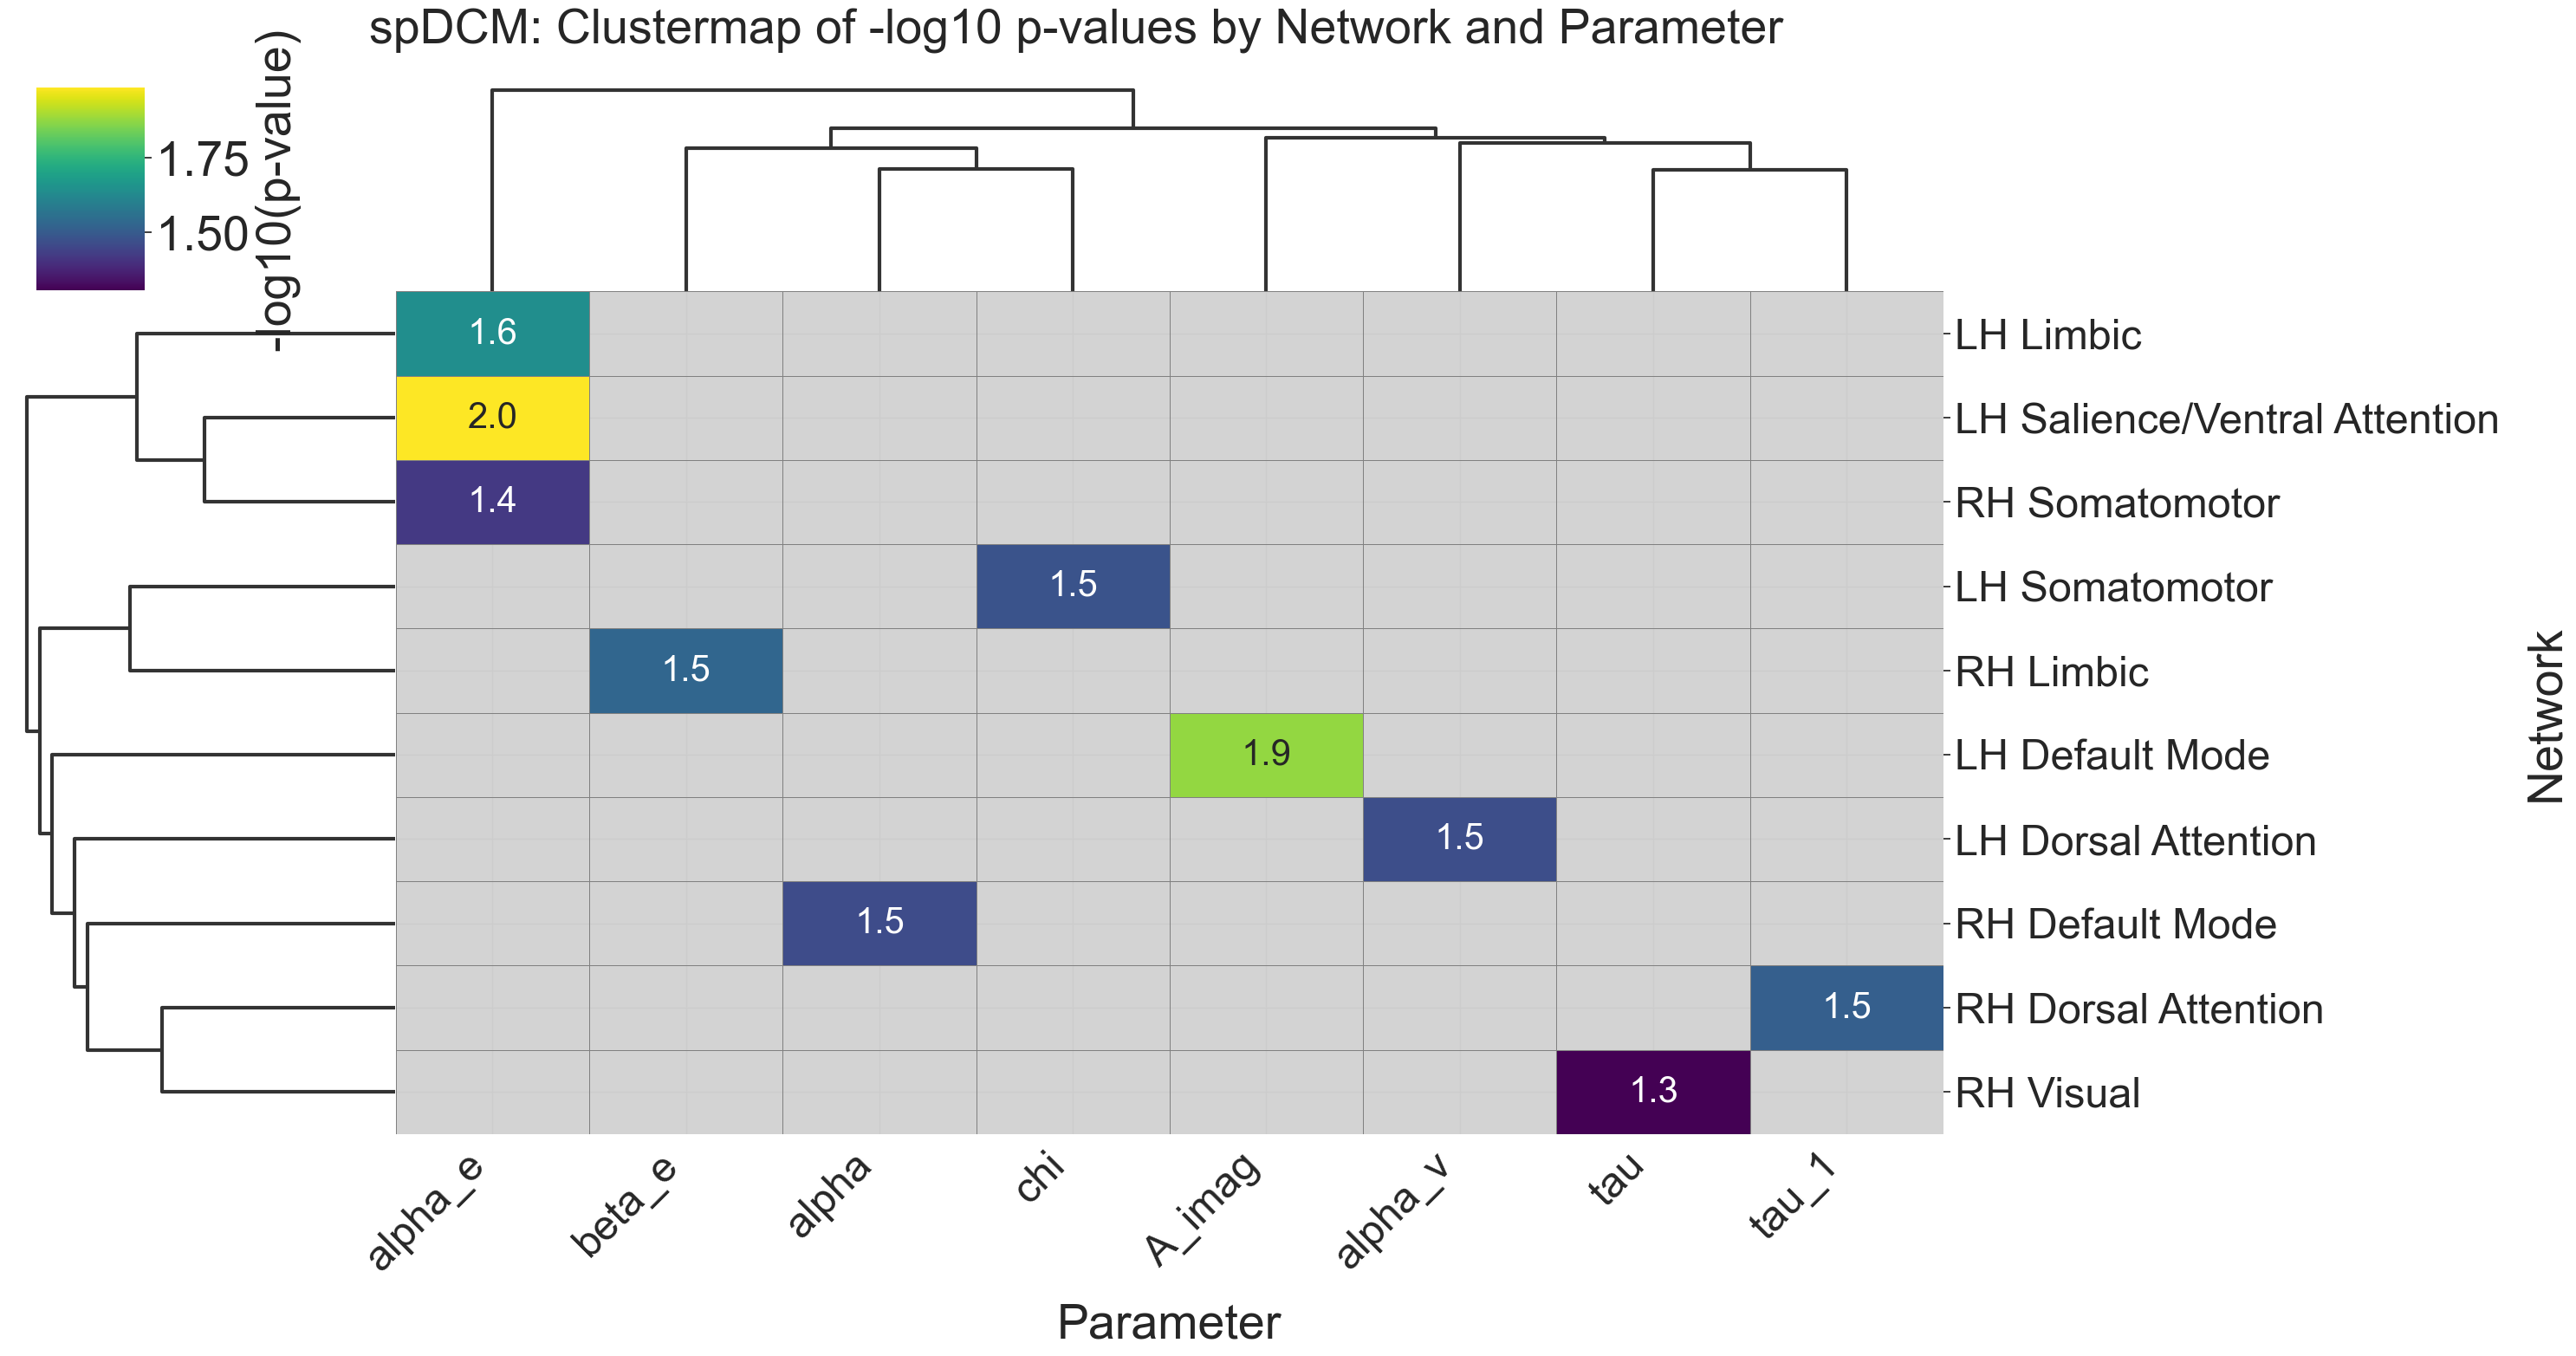

Statistically Significant Network–Parameter Pairs (p < 0.05):
                      network parameter  p_value
LH Salience/Ventral Attention   alpha_e 0.010299
              LH Default Mode    A_imag 0.013289
                    LH Limbic   alpha_e 0.022965
                    RH Limbic    beta_e 0.029627
          RH Dorsal Attention       tau 0.031043
               LH Somatomotor       chi 0.033191
          LH Dorsal Attention   alpha_v 0.034035
              RH Default Mode     alpha 0.034559
               RH Somatomotor   alpha_e 0.038078
                    RH Visual       mtt 0.049466

Row Dendrogram Linkage (Networks):
   Cluster 1  Cluster 2  Distance  Sample Count
0        3.0        8.0  1.062255           2.0
1        6.0        9.0  1.298416           2.0
2        2.0       10.0  1.437683           3.0
3        4.0        7.0  1.477938           2.0
4        5.0       11.0  1.714339           3.0
5        1.0       14.0  1.788604           4.0
6        0.0       15.0  1.

In [84]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.collections import LineCollection


pivot_pvals_net = results_df.pivot(index="network", columns="parameter", values="p_value")
log_pvals_net = -np.log10(pivot_pvals_net).sort_index().clip(upper=10)


rename_map = {"lamb": "lambda", "mtt": "tau", "tau": "tau_1"}
log_pvals_net.rename(columns=rename_map, inplace=True)

# Set threshold for annotations
threshold = 1.3

annot_data = log_pvals_net.copy()
annot_data = annot_data.where(annot_data > threshold, "")
annot_data = annot_data.applymap(lambda x: f"{x:.1f}" if isinstance(x, float) else "")
mask = log_pvals_net <= threshold

cmap = plt.cm.viridis
# Remove rows (networks) with no significant values above threshold
significant_rows = (log_pvals_net > threshold).any(axis=1)
log_pvals_net = log_pvals_net.loc[significant_rows]
annot_data = annot_data.loc[significant_rows]
mask = mask.loc[significant_rows]

# Remove columns (parameters) with no significant values above threshold
significant_cols = (log_pvals_net > threshold).any(axis=0)
log_pvals_net = log_pvals_net.loc[:, significant_cols]
annot_data = annot_data.loc[:, significant_cols]
mask = mask.loc[:, significant_cols]


g_net = sns.clustermap(
    log_pvals_net,
    cmap=cmap,
    figsize=(25, 13),
    yticklabels=True,
    xticklabels=True,
    mask=mask,
    annot=annot_data,
    fmt="",
    annot_kws={"size": 30},
    cbar_kws={"label": "-log10(p-value)"},
    linewidths=0.5,
    linecolor="gray"
)
g_net.ax_heatmap.set_facecolor("lightgray")

for ax in [g_net.ax_col_dendrogram, g_net.ax_row_dendrogram]:
    for collection in ax.collections:
        if isinstance(collection, LineCollection):
            collection.set_linewidth(3.0)


g_net.fig.suptitle(
    "spDCM: Clustermap of -log10 p-values by Network and Parameter",
    y=1.05, fontsize=40
)

plt.setp(g_net.ax_heatmap.xaxis.get_majorticklabels(), fontsize=35, rotation=45, ha="right")
plt.setp(g_net.ax_heatmap.yaxis.get_majorticklabels(), fontsize=35)

g_net.cax.set_ylabel("-log10(p-value)", fontsize=40)
g_net.cax.tick_params(labelsize=40)

g_net.ax_heatmap.set_xlabel("Parameter", fontsize=40, labelpad=20)
g_net.ax_heatmap.set_ylabel("Network", fontsize=40, labelpad=20)

plt.show()


significant_results = results_df[results_df["p_value"] < 0.05]


significant_summary = significant_results[["network", "parameter", "p_value"]]
significant_summary = significant_summary.sort_values(by="p_value")

print("Statistically Significant Network–Parameter Pairs (p < 0.05):")
print(significant_summary.to_string(index=False))


row_linkage = g_net.dendrogram_row.linkage
row_linkage_df = pd.DataFrame(row_linkage, columns=["Cluster 1", "Cluster 2", "Distance", "Sample Count"])
print("\nRow Dendrogram Linkage (Networks):")
print(row_linkage_df)


col_linkage = g_net.dendrogram_col.linkage
col_linkage_df = pd.DataFrame(col_linkage, columns=["Cluster 1", "Cluster 2", "Distance", "Sample Count"])
print("\nColumn Dendrogram Linkage (Parameters):")
print(col_linkage_df)

/var/folders/0j/8rw9s9dd56v924gjnszhk07m0000gn/T/ipykernel_59120/237346860.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot_data = annot_data.applymap(lambda x: f"{x:.1f}" if isinstance(x, float) else "")


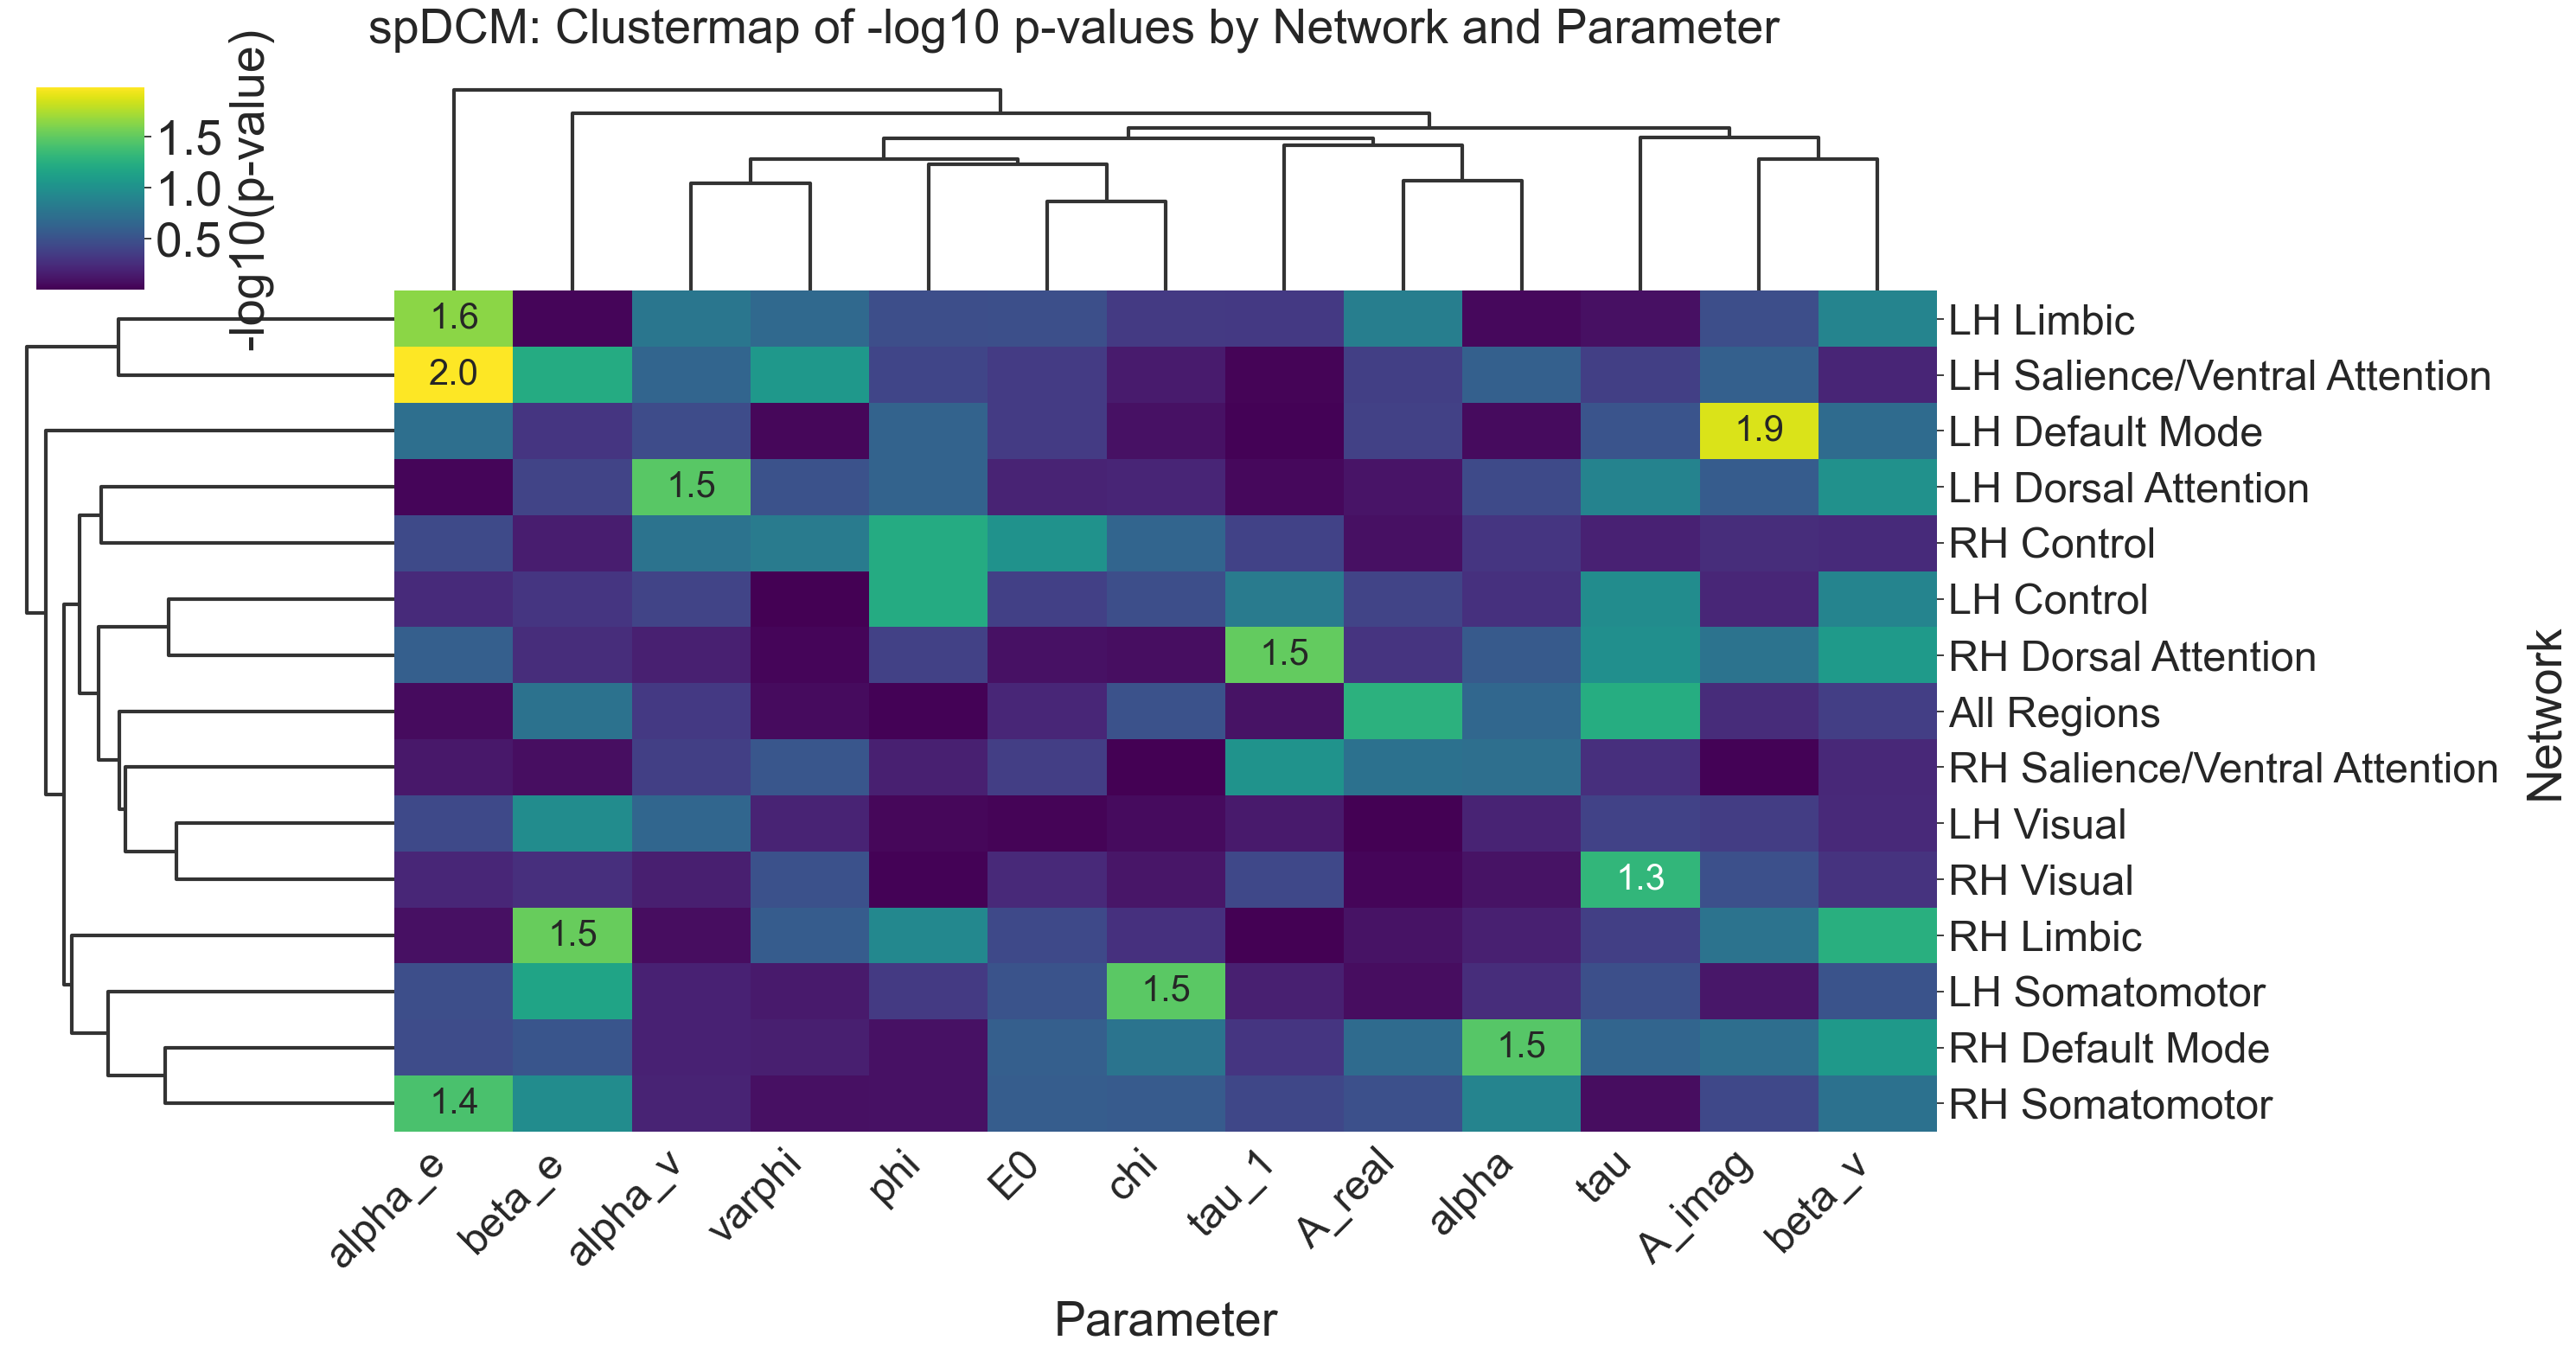

Statistically Significant Network–Parameter Pairs (p < 0.05):
                      network parameter  p_value
LH Salience/Ventral Attention   alpha_e 0.010299
              LH Default Mode    A_imag 0.013289
                    LH Limbic   alpha_e 0.022965
                    RH Limbic    beta_e 0.029627
          RH Dorsal Attention       tau 0.031043
               LH Somatomotor       chi 0.033191
          LH Dorsal Attention   alpha_v 0.034035
              RH Default Mode     alpha 0.034559
               RH Somatomotor   alpha_e 0.038078
                    RH Visual       mtt 0.049466

Row Dendrogram Linkage (Networks):
    Cluster 1  Cluster 2  Distance  Sample Count
0         7.0       14.0  1.357518           2.0
1         1.0       10.0  1.409629           2.0
2         9.0       13.0  1.429838           2.0
3        12.0       15.0  1.680306           3.0
4         0.0       18.0  1.714958           4.0
5         4.0        5.0  1.720698           2.0
6         6.0       

In [72]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.collections import LineCollection


pivot_pvals_net = results_df.pivot(index="network", columns="parameter", values="p_value")
log_pvals_net = -np.log10(pivot_pvals_net).sort_index().clip(upper=10)


rename_map = {"lamb": "lambda", "mtt": "tau", "tau": "tau_1"}
log_pvals_net.rename(columns=rename_map, inplace=True)

# Set threshold for annotations
threshold = 1.3

annot_data = log_pvals_net.copy()
annot_data = annot_data.where(annot_data > threshold, "")
annot_data = annot_data.applymap(lambda x: f"{x:.1f}" if isinstance(x, float) else "")


cmap = plt.cm.viridis


g_net = sns.clustermap(
    log_pvals_net,
    cmap=cmap,
    figsize=(25, 13),
    yticklabels=True,
    xticklabels=True,
    annot=annot_data,
    fmt="",
    annot_kws={"size": 30},
    cbar_kws={"label": "-log10(p-value)"},
)


for ax in [g_net.ax_col_dendrogram, g_net.ax_row_dendrogram]:
    for collection in ax.collections:
        if isinstance(collection, LineCollection):
            collection.set_linewidth(3.0)


g_net.fig.suptitle(
    "spDCM: Clustermap of -log10 p-values by Network and Parameter",
    y=1.05, fontsize=40
)

plt.setp(g_net.ax_heatmap.xaxis.get_majorticklabels(), fontsize=35, rotation=45, ha="right")
plt.setp(g_net.ax_heatmap.yaxis.get_majorticklabels(), fontsize=35)

g_net.cax.set_ylabel("-log10(p-value)", fontsize=40)
g_net.cax.tick_params(labelsize=40)

g_net.ax_heatmap.set_xlabel("Parameter", fontsize=40, labelpad=20)
g_net.ax_heatmap.set_ylabel("Network", fontsize=40, labelpad=20)

plt.show()


significant_results = results_df[results_df["p_value"] < 0.05]


significant_summary = significant_results[["network", "parameter", "p_value"]]
significant_summary = significant_summary.sort_values(by="p_value")

print("Statistically Significant Network–Parameter Pairs (p < 0.05):")
print(significant_summary.to_string(index=False))


row_linkage = g_net.dendrogram_row.linkage
row_linkage_df = pd.DataFrame(row_linkage, columns=["Cluster 1", "Cluster 2", "Distance", "Sample Count"])
print("\nRow Dendrogram Linkage (Networks):")
print(row_linkage_df)


col_linkage = g_net.dendrogram_col.linkage
col_linkage_df = pd.DataFrame(col_linkage, columns=["Cluster 1", "Cluster 2", "Distance", "Sample Count"])
print("\nColumn Dendrogram Linkage (Parameters):")
print(col_linkage_df)

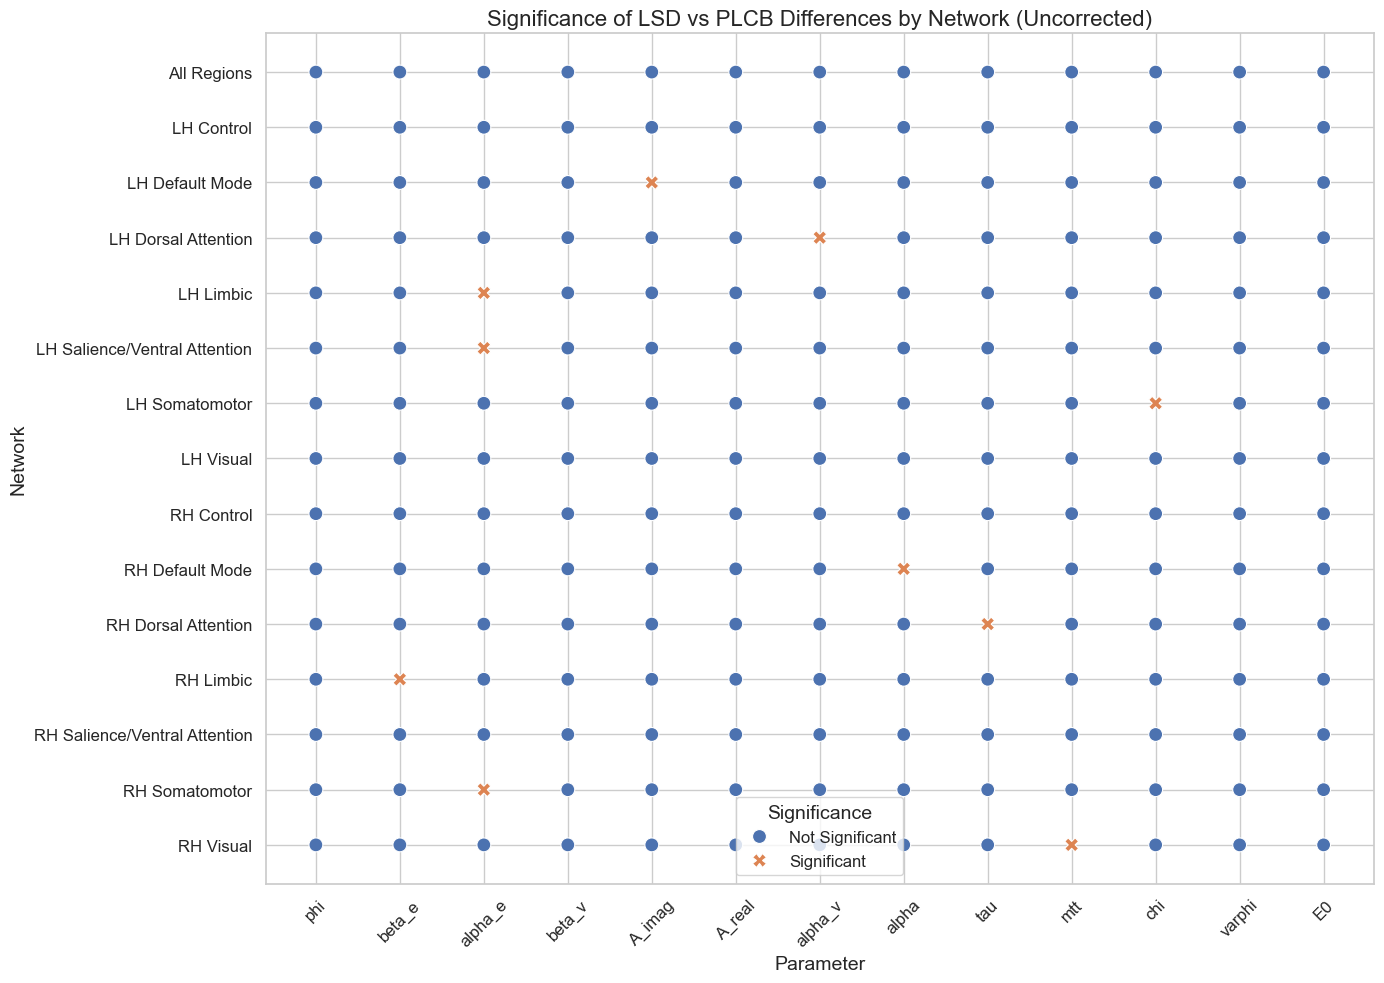

In [73]:
# Mark significance status in results_df
results_df["significance"] = results_df["reject_raw"].map({True: "Significant", False: "Not Significant"})

plt.figure(figsize=(14, 10))
sns.scatterplot(
    data=results_df,
    x="parameter", y="network",
    hue="significance", style="significance",
    s=100
)
plt.title("Significance of LSD vs PLCB Differences by Network (Uncorrected)", fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Parameter", fontsize=14)
plt.ylabel("Network", fontsize=14)
plt.legend(title="Significance", fontsize=12, title_fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_rel
from statsmodels.stats.multitest import multipletests

df = pd.read_csv("spdcm_all_data.csv")

# Parameters to test
params = ["phi", "varphi", "chi", "mtt", "tau",
          "alpha", "E0","A_real","A_imag","alpha_v", "beta_v", "alpha_e", "beta_e"]

# Filter and pivot
df_filtered = df[df["parameter"].isin(params)]
df_pivot = df_filtered.pivot_table(
    index=["subject", "roi", "experiment"],
    columns="parameter",
    values="value"
).reset_index()

results = []

for param in params:
    for roi in sorted(df_pivot["roi"].unique()):
        sub_df = df_pivot[df_pivot["roi"] == roi]
        wide = sub_df.pivot(index="subject", columns="experiment", values=param).dropna()

        if wide.shape[0] < 3:
            continue

        diff = wide["LSD"] - wide["PLCB"]
        t_stat, p_val = ttest_rel(wide["LSD"], wide["PLCB"])
        mean_diff = diff.mean()
        std_diff = diff.std(ddof=1)
        cohen_d = mean_diff / std_diff if std_diff != 0 else np.nan

        results.append({
            "roi": roi,
            "parameter": param,
            "mean_diff": mean_diff,
            "std_diff": std_diff,
            "cohen_d": cohen_d,
            "t_stat": t_stat,
            "p_value": p_val
        })

roi_df = pd.DataFrame(results)

# Multiple testing correction
pvals = roi_df["p_value"].fillna(1).values
roi_df["p_fdr_bh"] = multipletests(pvals, method="fdr_bh")[1]
roi_df["p_bonferroni"] = multipletests(pvals, method="bonferroni")[1]
roi_df["p_holm"] = multipletests(pvals, method="holm")[1]

roi_df["reject_raw"] = roi_df["p_value"] < 0.05
roi_df["reject_fdr_bh"] = roi_df["p_fdr_bh"] < 0.05
roi_df["reject_bonferroni"] = roi_df["p_bonferroni"] < 0.05
roi_df["reject_holm"] = roi_df["p_holm"] < 0.05

def interpret_delta(p, mean):
    direction = "↑ LSD > PLCB" if mean > 0 else "↓ LSD < PLCB"
    if p < 0.001:
        return f"highly significant, {direction}"
    elif p < 0.01:
        return f"significant, {direction}"
    elif p < 0.05:
        return f"marginally significant, {direction}"
    else:
        return f"not significant, {direction}"

# Add interpretation columns
roi_df["interpret_raw"] = roi_df.apply(lambda row: interpret_delta(row["p_value"], row["mean_diff"]), axis=1)
roi_df["interpret_fdr_bh"] = roi_df.apply(lambda row: interpret_delta(row["p_fdr_bh"], row["mean_diff"]), axis=1)
roi_df["interpret_bonferroni"] = roi_df.apply(lambda row: interpret_delta(row["p_bonferroni"], row["mean_diff"]), axis=1)
roi_df["interpret_holm"] = roi_df.apply(lambda row: interpret_delta(row["p_holm"], row["mean_diff"]), axis=1)

roi_df = roi_df[[
    "roi", "parameter", "mean_diff", "std_diff", "cohen_d", "t_stat",
    "p_value", "reject_raw", "interpret_raw",
    "p_fdr_bh", "reject_fdr_bh", "interpret_fdr_bh",
    "p_bonferroni", "reject_bonferroni", "interpret_bonferroni",
    "p_holm", "reject_holm", "interpret_holm"
]]

roi_df.sort_values(["roi", "parameter"], inplace=True)
roi_df.reset_index(drop=True, inplace=True)

roi_df


roi parameter  mean_diff  std_diff   cohen_d    t_stat   p_value  \
0       0    A_imag   0.025964  0.064918  0.399947  1.548987  0.143689   
1       0    A_real   0.080000  0.139745  0.572472  2.217174  0.043670   
2       0        E0  -0.030489  0.146452 -0.208186 -0.806303  0.433552   
3       0     alpha   0.014248  0.188847  0.075446  0.292202  0.774418   
4       0   alpha_e  -0.055180  0.408398 -0.135114 -0.523296  0.608952   
...   ...       ...        ...       ...       ...       ...       ...   
1295   99       chi   0.010757  0.253526  0.042431  0.164333  0.871818   
1296   99       mtt  -0.348699  1.548083 -0.225246 -0.872373  0.397720   
1297   99       phi  -0.063104  0.342226 -0.184393 -0.714150  0.486872   
1298   99       tau  -1.394943  5.873959 -0.237479 -0.919753  0.373278   
1299   99    varphi  -0.052821  0.215843 -0.244719 -0.947791  0.359310   

      reject_raw                         interpret_raw  p_fdr_bh  \
0          False         not significant, ↑ LSD > PLCB  0.932291   
1           True  marginally significant, ↑ LSD > PLCB  0.932291   
2          False         not significant, ↓ LSD < PLCB  0.972396   
3          False         not significant, ↑ LSD > PLCB  0.986938   
4          False         not significant, ↓ LSD < PLCB  0.976126   
...          ...                                   ...       ...   
1295       False         not significant, ↑ LSD > PLCB  0.986938   
1296       False         not significant, ↓ LSD < PLCB  0.964103   
1297       False         not significant, ↓ LSD < PLCB  0.972396   
1298       False         not significant, ↓ LSD < PLCB  0.958983   
1299       False         not significant, ↓ LSD < PLCB  0.958983   

      reject_fdr_bh               interpret_fdr_bh  p_bonferroni  \
0             False  not significant, ↑ LSD > PLCB           1.0   
1             False  not significant, ↑ LSD > PLCB           1.0   
2             False  not significant, ↓ LSD < PLCB           1.0   
3             False  not significant, ↑ LSD > PLCB           1.0   
4             False  not significant, ↓ LSD < PLCB           1.0   
...             ...                            ...           ...   
1295          False  not significant, ↑ LSD > PLCB           1.0   
1296          False  not significant, ↓ LSD < PLCB           1.0   
1297          False  not significant, ↓ LSD < PLCB           1.0   
1298          False  not significant, ↓ LSD < PLCB           1.0   
1299          False  not significant, ↓ LSD < PLCB           1.0   

      reject_bonferroni           interpret_bonferroni  p_holm  reject_holm  \
0                 False  not significant, ↑ LSD > PLCB     1.0        False   
1                 False  not significant, ↑ LSD > PLCB     1.0        False   
2                 False  not significant, ↓ LSD < PLCB     1.0        False   
3                 False  not significant, ↑ LSD > PLCB     1.0        False   
4                 False  not significant, ↓ LSD < PLCB     1.0        False   
...                 ...                            ...     ...          ...   
1295              False  not significant, ↑ LSD > PLCB     1.0        False   
1296              False  not significant, ↓ LSD < PLCB     1.0        False   
1297              False  not significant, ↓ LSD < PLCB     1.0        False   
1298              False  not significant, ↓ LSD < PLCB     1.0        False   
1299              False  not significant, ↓ LSD < PLCB     1.0        False   

                     interpret_holm  
0     not significant, ↑ LSD > PLCB  
1     not significant, ↑ LSD > PLCB  
2     not significant, ↓ LSD < PLCB  
3     not significant, ↑ LSD > PLCB  
4     not significant, ↓ LSD < PLCB  
...                             ...  
1295  not significant, ↑ LSD > PLCB  
1296  not significant, ↓ LSD < PLCB  
1297  not significant, ↓ LSD < PLCB  
1298  not significant, ↓ LSD < PLCB  
1299  not significant, ↓ LSD < PLCB  

[1300 rows x 18 columns]

In [75]:
# Filter rows where raw p-value is significant
sig_roi = roi_df[roi_df["p_value"] <= 0.05].copy()

sig_roi.sort_values("roi", ascending=False, inplace=True)

sig_roi

roi parameter  mean_diff  std_diff   cohen_d    t_stat   p_value  \
1294   99    beta_v  -0.205807  0.333177 -0.617710 -2.392381  0.031323   
1293   99    beta_e  -0.183116  0.304143 -0.602073 -2.331820  0.035160   
1236   95    A_real   0.060434  0.086915  0.695321  2.692966  0.017496   
1207   92       tau   5.933955  7.814415  0.759360  2.940989  0.010736   
1204   92       chi   0.093878  0.150100  0.625439  2.422313  0.029576   
1203   92    beta_v  -0.253760  0.416853 -0.608752 -2.357686  0.033469   
1177   90    beta_v  -0.138076  0.230987 -0.597767 -2.315142  0.036292   
1173   90     alpha  -0.094414  0.153982 -0.613151 -2.374724  0.032398   
1169   89    varphi   0.099084  0.177741  0.557464  2.159050  0.048689   
1147   88     alpha   0.106416  0.172714  0.616139  2.386297  0.031689   
1055   81        E0   0.124643  0.159466  0.781626  3.027226  0.009050   
1021   78    beta_v  -0.279778  0.400192 -0.699110 -2.707641  0.017000   
997    76       mtt   0.861273  1.450050  0.593960  2.300399  0.037322   
945    72       mtt   1.238120  1.597471  0.775050  3.001754  0.009518   
922    70    varphi  -0.164729  0.179848 -0.915930 -3.547383  0.003218   
911    70    A_real  -0.093676  0.121715 -0.769636 -2.980786  0.009922   
864    66    beta_e  -0.260475  0.276101 -0.943405 -3.653793  0.002605   
862    66   alpha_e   0.223548  0.360845  0.619512  2.399359  0.030907   
826    63    beta_v  -0.188157  0.337059 -0.558232 -2.162022  0.048420   
758    58   alpha_e   0.284955  0.495523  0.575060  2.227196  0.042855   
739    56       tau   5.753710  7.443989  0.772934  2.993559  0.009674   
663    51    A_imag   0.030679  0.043591  0.703775  2.725710  0.016409   
657    50    beta_v   0.225142  0.295813  0.761096  2.947713  0.010594   
637    49    A_imag   0.056539  0.061837  0.914322  3.541154  0.003258   
634    48       phi   0.177406  0.312446  0.567796  2.199064  0.045179   
608    46       phi   0.201194  0.347182  0.579505  2.244414  0.041488   
602    46   alpha_e   0.195761  0.334865  0.584596  2.264131  0.039974   
593    45       chi  -0.097168  0.164171 -0.591871 -2.292306  0.037899   
576    44   alpha_e   0.255826  0.351906  0.726974  2.815559  0.013753   
559    43    A_imag   0.032100  0.053173  0.603693  2.338092  0.034743   
546    42    A_imag   0.025725  0.045487  0.565543  2.190340  0.045924   
523    40     alpha  -0.101772  0.155046 -0.656396 -2.542209  0.023469   
513    39    beta_e  -0.199336  0.331730 -0.600897 -2.327263  0.035466   
484    37     alpha  -0.091553  0.155485 -0.588821 -2.280496  0.038756   
397    30    beta_v  -0.327439  0.475732 -0.688286 -2.665719  0.018454   
390    30    A_imag   0.036666  0.056299  0.651271  2.522360  0.024389   
330    25   alpha_v   0.344305  0.268187  1.283826  4.972236  0.000205   
312    24    A_imag   0.048860  0.070753  0.690568  2.674558  0.018138   
291    22   alpha_v   0.283771  0.388778  0.729904  2.826904  0.013449   
289    22     alpha  -0.123167  0.146881 -0.838551 -3.247692  0.005839   
287    22    A_real  -0.101690  0.139960 -0.726561 -2.813958  0.013796   
228    17    beta_v  -0.269070  0.222233 -1.210757 -4.689241  0.000348   
211    16     alpha  -0.109537  0.193703 -0.565491 -2.190139  0.045941   
212    16   alpha_e  -0.161432  0.261236 -0.617956 -2.393334  0.031265   
161    12   alpha_v  -0.177946  0.314931 -0.565033 -2.188362  0.046094   
146    11     alpha  -0.111511  0.181120 -0.615678 -2.384511  0.031798   
145    11        E0   0.056463  0.091112  0.619708  2.400118  0.030862   
138    10       chi  -0.161830  0.160989 -1.005222 -3.893207  0.001623   
136    10    beta_e   0.158600  0.198808  0.797753  3.089686  0.007994   
109     8   alpha_v   0.226356  0.321763  0.703485  2.724585  0.016445   
86      6       chi   0.107281  0.193354  0.554841  2.148892  0.049619   
84      6    beta_e  -0.169200  0.230778 -0.733172 -2.839564  0.013117   
69      5   alpha_e   0.211522  0.342034  0.618424  2.395147  0.031157   
43      3 

In [76]:
# Bonferroni 
sig_bonf_roi = roi_df[roi_df["reject_bonferroni"] == True]
sig_bonf_roi


Empty DataFrame
Columns: [roi, parameter, mean_diff, std_diff, cohen_d, t_stat, p_value, reject_raw, interpret_raw, p_fdr_bh, reject_fdr_bh, interpret_fdr_bh, p_bonferroni, reject_bonferroni, interpret_bonferroni, p_holm, reject_holm, interpret_holm]
Index: []

In [77]:
# FDR BH significant
sig_fdr_roi = roi_df[roi_df["reject_fdr_bh"] == True]
sig_fdr_roi

Empty DataFrame
Columns: [roi, parameter, mean_diff, std_diff, cohen_d, t_stat, p_value, reject_raw, interpret_raw, p_fdr_bh, reject_fdr_bh, interpret_fdr_bh, p_bonferroni, reject_bonferroni, interpret_bonferroni, p_holm, reject_holm, interpret_holm]
Index: []

In [78]:
sig_holm_roi = roi_df[roi_df["reject_holm"] == True]
sig_holm_roi 

Empty DataFrame
Columns: [roi, parameter, mean_diff, std_diff, cohen_d, t_stat, p_value, reject_raw, interpret_raw, p_fdr_bh, reject_fdr_bh, interpret_fdr_bh, p_bonferroni, reject_bonferroni, interpret_bonferroni, p_holm, reject_holm, interpret_holm]
Index: []

In [79]:
consistently_sig_roi = roi_df[
    (roi_df["reject_raw"] == True) &
    (roi_df["reject_fdr_bh"] == True) &
    (roi_df["reject_bonferroni"] == True) &
    (roi_df["reject_holm"] == True)
]
consistently_sig_roi

Empty DataFrame
Columns: [roi, parameter, mean_diff, std_diff, cohen_d, t_stat, p_value, reject_raw, interpret_raw, p_fdr_bh, reject_fdr_bh, interpret_fdr_bh, p_bonferroni, reject_bonferroni, interpret_bonferroni, p_holm, reject_holm, interpret_holm]
Index: []

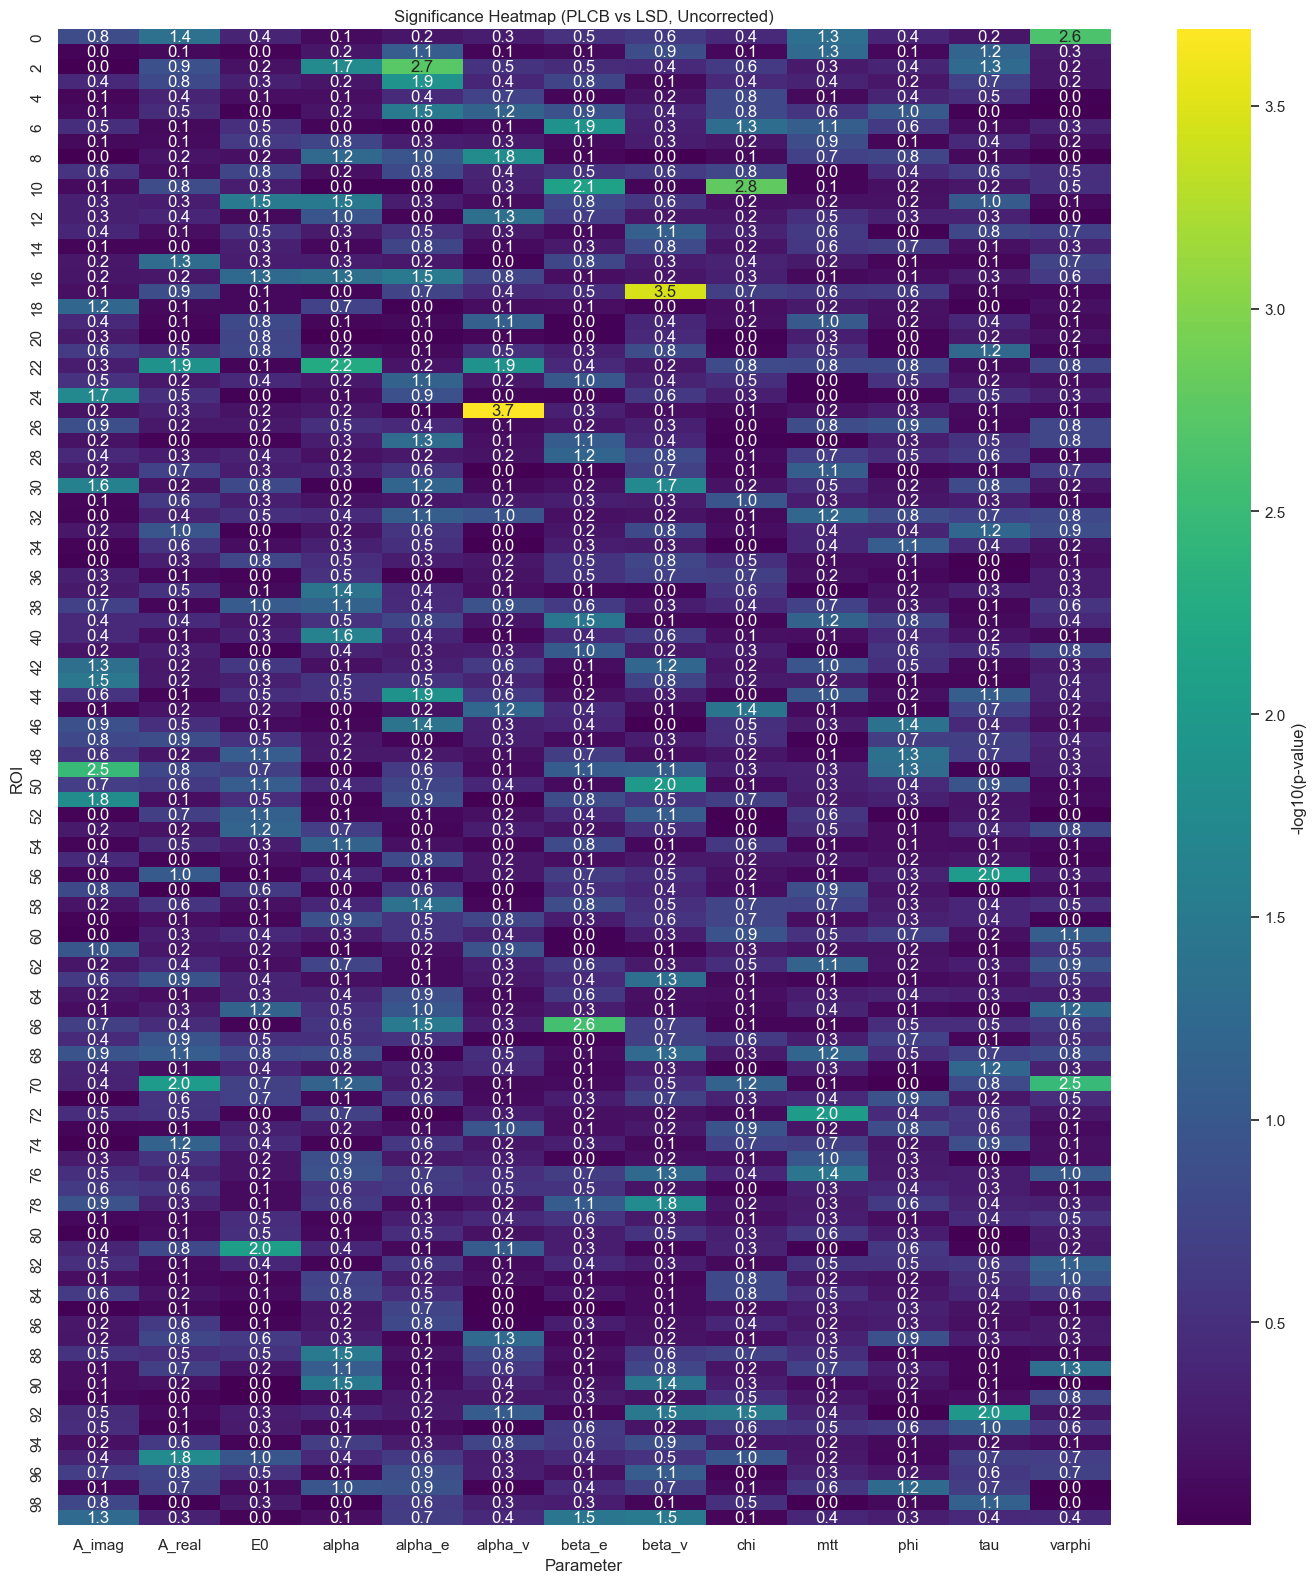

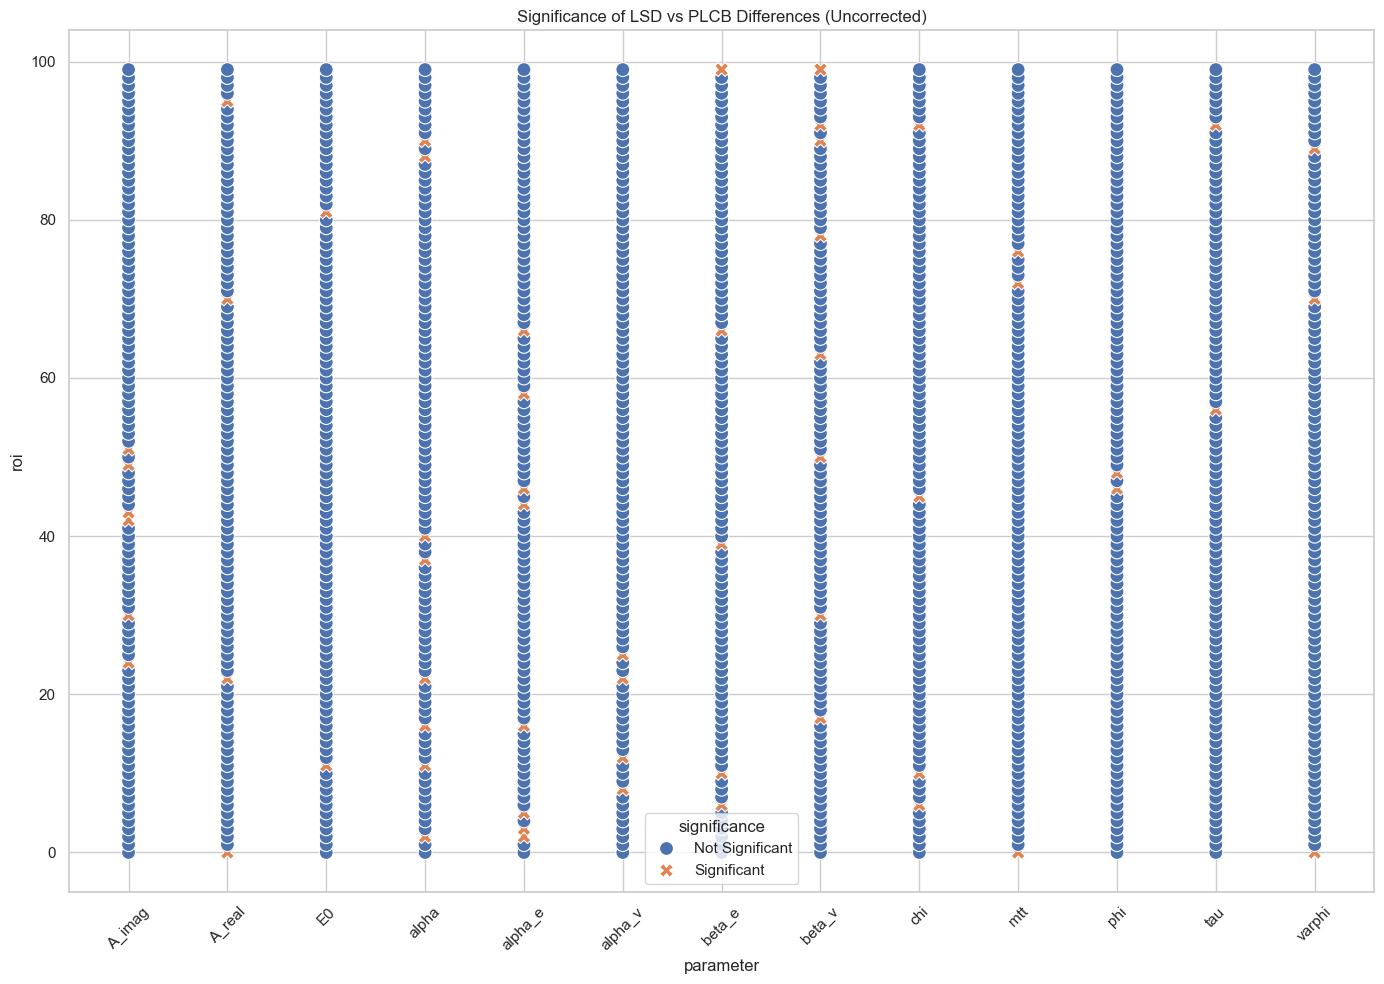

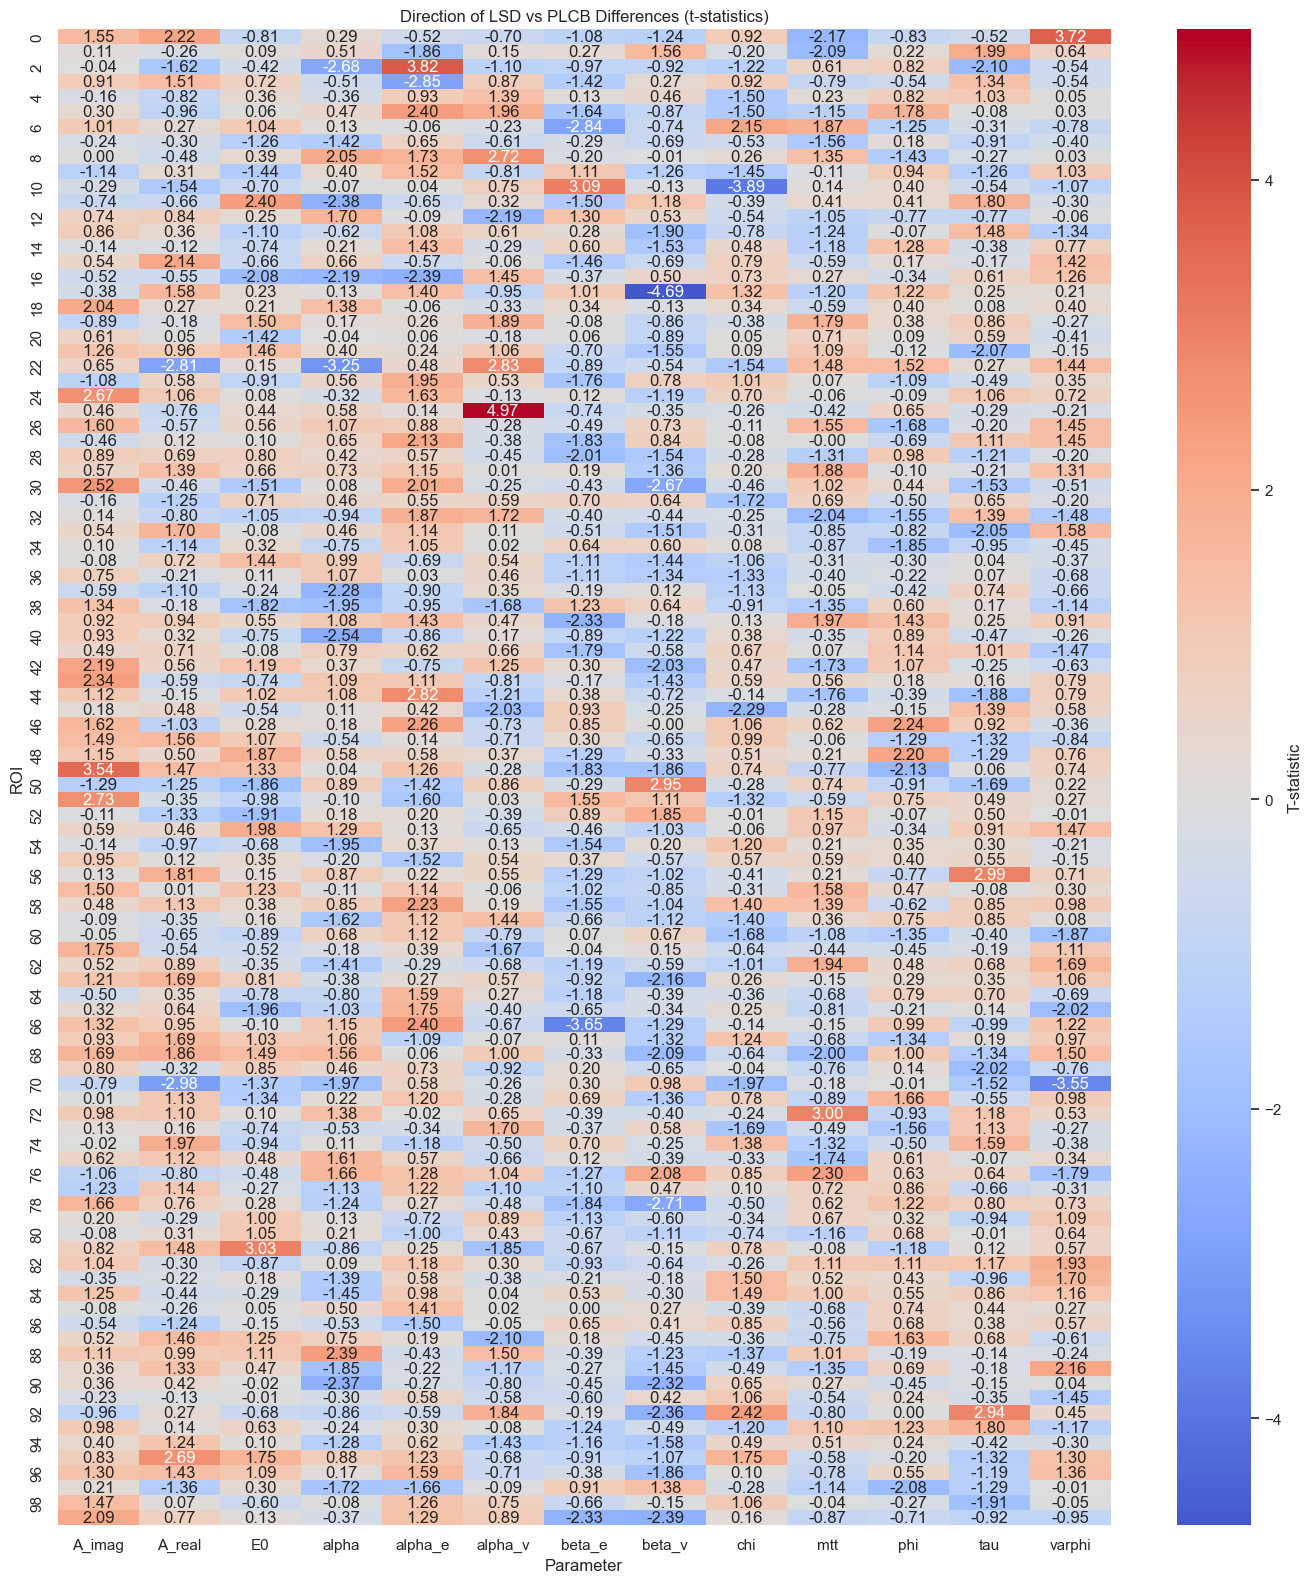

In [80]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Pivot to ROI × parameter matrix of p-values
heatmap_df = roi_df.pivot(index="roi", columns="parameter", values="p_value")

# Convert p-values to -log10 scale (clip very low to avoid inf)
log_pvals = -np.log10(heatmap_df.clip(lower=1e-10))

plt.figure(figsize=(14, 16))
sns.heatmap(
    log_pvals,
    cmap="viridis",
    cbar_kws={"label": "-log10(p-value)"},
    annot=True,
    fmt=".1f"
)
plt.title("Significance Heatmap (PLCB vs LSD, Uncorrected)")
plt.ylabel("ROI")
plt.xlabel("Parameter")
plt.tight_layout()
plt.show()

# Mark significance status
roi_df["significance"] = roi_df["reject_raw"].map({True: "Significant", False: "Not Significant"})

plt.figure(figsize=(14, 10))
sns.scatterplot(
    data=roi_df,
    x="parameter", y="roi",
    hue="significance", style="significance",
    s=100
)
plt.title("Significance of LSD vs PLCB Differences (Uncorrected)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Pivot to ROI × parameter matrix of t-statistics
t_stat_matrix = roi_df.pivot(index="roi", columns="parameter", values="t_stat")

plt.figure(figsize=(14, 16))
sns.heatmap(
    t_stat_matrix,
    cmap="coolwarm",
    center=0,
    annot=True,
    fmt=".2f",
    cbar_kws={"label": "T-statistic"}
)
plt.title("Direction of LSD vs PLCB Differences (t-statistics)")
plt.ylabel("ROI")
plt.xlabel("Parameter")
plt.tight_layout()
plt.show()
